In [1]:
import pygame, sys, random
import numpy as np
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
import math
import matplotlib.pyplot as plt
import pylab
from fractions import Fraction

num_episodes = 10

obstacleRadius = 10
agentRadius = 10

# get size of state and action from environment

boundaryPos = [100, 100]
boundaryLength = [70,70]
boundaryRadius = 40
dispSize = [1280, 960]
initPosAgentStandard = [dispSize[0] - 100, 100]#dispSize[1]]
initPosAgent = initPosAgentStandard#[boundaryPos[0] + boundaryLength[0] / 2, boundaryPos[1] + boundaryLength[1] / 2]
goalPos = [100, 900]
goalAngle = 0#random.randrange(0, 360) * math.pi / 180

obstacleRandomRange = 1000

moveObstacles = True
action_size = 9
obsNumber = 100
state_size = 2
# state_size = obsNumber + 1

Using TensorFlow backend.


In [2]:
# A2C(Advantage Actor-Critic) agent
class A2CAgent:
    def __init__(self, state_size, action_size):
        self.load_model = True
        
        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size
        self.value_size = 1

        # These are hyper parameters for the Policy Gradient
        self.discount_factor = 0.99
        self.actor_lr = 0.00002
        self.critic_lr = 0.00005

        # create model for policy network
        self.actor = self.build_actor()
        self.critic = self.build_critic()

        if self.load_model:
            self.actor.load_weights("./Practice004_DataSave/Backup/Actor_Rev_171221_1000.h5")
            self.critic.load_weights("./Practice004_DataSave/Backup/Critic_Rev_171221_1000.h5")

    # approximate policy and value using Neural Network
    # actor: state is input and probability of each action is output of model
    def build_actor(self):
        actor = Sequential()
        actor.add(Dense(128, input_dim=self.state_size, activation='relu', kernel_initializer='glorot_normal'))
        actor.add(Dense(self.action_size, activation='softmax', kernel_initializer='glorot_normal'))
        actor.summary()
        # See note regarding crossentropy in cartpole_reinforce.py
        actor.compile(loss='categorical_crossentropy', optimizer=Adam(lr=self.actor_lr))
        return actor

    # critic: state is input and value of state is output of model
    def build_critic(self):
        critic = Sequential()
        critic.add(Dense(128, input_dim=self.state_size, activation='relu', kernel_initializer='glorot_normal'))
        critic.add(Dense(self.value_size, activation='linear', kernel_initializer='glorot_normal'))
        critic.summary()
        critic.compile(loss="mse", optimizer=Adam(lr=self.critic_lr))
        return critic

    # using the output of policy network, pick action stochastically
    def get_action(self, state):
        policy = self.actor.predict(state, batch_size=1).flatten()
#         print policy
        return policy
#         return np.random.choice(self.action_size, 1, p=policy)[0]

    # update policy network every episode
    def train_model(self, state, action, reward, next_state, done):
        target = np.zeros((1, self.value_size))
        advantages = np.zeros((1, self.action_size))

        value = self.critic.predict(state)[0]
        next_value = self.critic.predict(next_state)[0]

        if done:
            advantages[0][action] = reward - value
            target[0][0] = reward
        else:
            advantages[0][action] = reward + self.discount_factor * (next_value) - value
            target[0][0] = reward + self.discount_factor * next_value

        self.actor.fit(state, advantages, epochs=1, verbose=0)
        self.critic.fit(state, target, epochs=1, verbose=0)

In [3]:
def stateGenerator(obsPosition, agtPosition, idx):
    returnSum = []
    if idx != -1:
        returnSum = returnSum + [agtPosition[0] - obsPosition[idx][0], agtPosition[1] - obsPosition[idx][1]]
    else:
        returnSum = returnSum + [agtPosition[0] - obsPosition[0], agtPosition[1] - obsPosition[1]]
    returnSum = np.reshape(returnSum, [1, 2])
    return returnSum

In [4]:
def takeAction(action):
    xAction = 0
    yAction = 0
    if action == 0:
        xAction = 1
    elif action == 1:
        xAction = 1
        yAction = 1
    elif action == 2:
        xAction = 1
        yAction = -1            
    elif action == 3:
        xAction = -1
        yAction = 1
    elif action == 4:
        xAction = -1
    elif action == 5:
        xAction = -1
        yAction = -1
    elif action == 6:
        yAction = -1
    elif action == 7:
        yAction = 1
    elif action == 8:
        xAction = 0
        yAction = 0
        
    return [xAction, yAction]

In [5]:
def rangeFinder(allObsPos, rangeCenter):
    countObs = 0
    rangeObstacle = [[0,0] for _ in range(obsNumber)]
    for i in range(0, obsNumber):
        if math.sqrt((rangeCenter[0] - allObsPos[i][0])**2 + (rangeCenter[1] - allObsPos[i][1])**2) < boundaryRadius:
            rangeObstacle[countObs] = allObsPos[i]
            countObs += 1
            
    return [countObs, rangeObstacle]

In [6]:
def goalFinder(agtPos):
    if goalPos[0] == agtPos[0]:
        if goalPos[1] > agtPos[1]:
            goalAngle = 90 * math.pi / 180
        else:
            goalAngle = -90 * math.pi / 180
    else:
        goalAngle = math.atan(1.0*(goalPos[1]-agtPos[1])/(goalPos[0]-agtPos[0]))
    if goalPos[0] < agtPos[0]:
        goalAngle += math.pi
        
    tmpGoal = [0,0]
    tmpGoal[0] = int(math.floor(agtPos[0] + boundaryRadius * math.cos(goalAngle)))
    tmpGoal[1] = int(math.floor(agtPos[1] + boundaryRadius * math.sin(goalAngle)))
    return tmpGoal

In [7]:
def nearestAction(actionIdx):
    nearAction = []
    if actionIdx == 0:
        nearAction = [1, 2]
    elif actionIdx == 1:
        nearAction = [0, 7]
    elif actionIdx == 2:
        nearAction = [0, 6]
    elif actionIdx == 3:
        nearAction = [4, 7]
    elif actionIdx == 4:
        nearAction = [3, 5]
    elif actionIdx == 5:
        nearAction = [4, 6]
    elif actionIdx == 6:
        nearAction = [5, 2]
    elif actionIdx == 7:
        nearAction = [1, 3]
    else:
        nearAction = [8, 8]
    return nearAction

In [ ]:
pygame.init()
screen = pygame.display.set_mode(dispSize)
screen.fill([200, 200, 200])

# make A2C agent
agent = A2CAgent(state_size, action_size)

rList, episodes = [], []

# Make Obstacles (obsNumber)
obstaclePos = [[0, 0] for _ in range(obsNumber)]
for i in range(0,obsNumber):
#     obsRadius = random.randrange(agentRadius + obstacleRadius + 10, obstacleRandomRange)
#     obsAngle = random.randrange(90,180) * math.pi / 180
#     obstaclePos[i][0] = int(initPosAgent[0] + obsRadius * math.cos(obsAngle)) #boundaryPos[0] + random.randrange(1, boundaryLength[0])
#     obstaclePos[i][1] = int(initPosAgent[1] + obsRadius * math.sin(obsAngle)) #boundaryPos[1] + random.randrange(1, boundaryLength[1])
    obstaclePos[i][0] = int(initPosAgent[0] - random.randrange(0, dispSize[0]))
    obstaclePos[i][1] = int(initPosAgent[1] + random.randrange(0, dispSize[1]))

for e in range(num_episodes):
    # Initialize
    done = False
    score = 0
    x = initPosAgent[0]
    y = initPosAgent[1]
    print("Episode ", e, "Starts!")
    
    while not done:
        [rangeObsNumber, rangeObsPos] = rangeFinder(obstaclePos, initPosAgent)
#         print rangeObsNumber
        tmpAction = []
        for i in range(0,rangeObsNumber):
            state = stateGenerator(rangeObsPos, [x,y], i)
            policyArr = agent.get_action(state)
            if i == 0:
                tmpAction = (1 - policyArr)
            else:
                tmpAction = tmpAction * (1 - policyArr)
        print("0: ", tmpAction)
        if tmpAction != []:
            for j in range(0, 9):
                if tmpAction[j] > 0.99999:
                    tmpAction[j] = 1
                else:
                    tmpAction[j] = 0
            
#         tmpAction = [round(elem,0) for elem in tmpAction]

        if rangeObsNumber == 0:
            tmpAction = [1.0/9.0 for _ in range(0, 9)]
        
        tmpGoalPos = goalFinder([x, y])
        state = stateGenerator(tmpGoalPos, [x,y], -1)
        policyArr = agent.get_action(state)
#         nearAction = nearestAction(np.argmax(policyArr))
#         policyArr[nearAction[0]] = max(policyArr)/3
#         policyArr[nearAction[1]] = max(policyArr)/3
        print("1: ", tmpAction)        

#         for i in range(0,9):
#             if policyArr[i] == max(policyArr):
#                 break
#         policyArr = [1.0 for _ in range(0,9)]
#         policyArr[i] = 10000.0
        tmpAction = tmpAction * np.asarray(policyArr)
        
        tmpAction = tmpAction / np.sum(tmpAction)
        print("2: ", policyArr)
        print("3: ", tmpAction)
        print("==============================================================================================================")
        action = np.random.choice(action_size, 1, p = tmpAction)[0]
        
        xMove = 0
        yMove = 0

        [xMove, yMove] = takeAction(action)

        x = x + xMove
        y = y + yMove

        wallFlag = 0
        collisionFlag = 0
#         [x, y] = ckWall(x, y)
        pygame.draw.circle(screen, [100, 100, 255], [x,y], 10, 0)
#         next_state = stateGenerator(obstaclePos, [x,y])
        initPosAgent = [x,y]

        if math.sqrt((x -  goalPos[0])**2 + (y - goalPos[1])**2) <= agentRadius:
            print("Goal Reached!")
            collisionFlag = 1
            done = True
        for i in range(0,obsNumber):
            if moveObstacles:
                obstaclePos[i][0] = obstaclePos[i][0] + random.randrange(-1,2)
                obstaclePos[i][1] = obstaclePos[i][1] + random.randrange(-1,2)
                
            pygame.draw.circle(screen, [255, 50, 50], obstaclePos[i], obstacleRadius, 0)
            if math.sqrt((x - obstaclePos[i][0])**2 + (y - obstaclePos[i][1])**2) < 19:
                print("Collision!")
                collisionFlag = -1
                done = True
#                 break
        
        if not done:
            reward = 0.1

        else:
            if collisionFlag == 1:
                reward = 10000 * math.cos(math.atan2(y - initPosAgent[1], x - initPosAgent[0]))
                rList.append(1)
            elif collisionFlag == -1:
                reward = -10000
                rList.append(0)
        
#         agent.train_model(state, action, reward, next_state, done)
        
        score += reward
#         state = next_state
#         if score >= 10000:
#             print "Success!"
#             done = True
        pygame.draw.circle(screen, [255,100,100], initPosAgent, boundaryRadius, 2)

        if done:
            # every episode, plot the play time
            initPosAgent = initPosAgentStandard
            obstaclePos = [[0, 0] for _ in range(obsNumber)]
            for i in range(0,obsNumber):
#                 obsRadius = random.randrange(agentRadius + obstacleRadius + 100, obstacleRandomRange)
#                 obsAngle = random.randrange(90,180) * math.pi / 180
#                 obstaclePos[i][0] = int(initPosAgent[0] + obsRadius * math.cos(obsAngle))
#                 obstaclePos[i][1] = int(initPosAgent[1] + obsRadius * math.sin(obsAngle))
                obstaclePos[i][0] = int(initPosAgent[0] - random.randrange(0, dispSize[0]))
                obstaclePos[i][1] = int(initPosAgent[1] + random.randrange(0, dispSize[1]))

            episodes.append(e)
            
        #circle(Surface, color, pos, radius, width=0)
        pygame.draw.circle(screen, [100,255,100], goalPos, 10, 2)
        pygame.draw.circle(screen, [0, 255, 200], tmpGoalPos, 5, 5)
        pygame.display.flip()
        screen.fill([220,220,220])
    print score


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 1161      
Total params: 1,545
Trainable params: 1,545
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________
('Episode ', 0, 'Starts!')
('0: ', [])
('1: ', [0.1111111111111111, 0.111111

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.74455587e-08,   6.97652336e-09,   3.45432688e-03,
         9.89314198e-01,   3.58678481e-05,   5.16084675e-03,
         2.16342869e-07,   2.03410233e-03,   3.49075918e-07], dtype=float32))
('3: ', array([  2.74455603e-08,   6.97652376e-09,   3.45432708e-03,
         9.89314256e-01,   3.58678501e-05,   5.16084705e-03,
         2.16342881e-07,   2.03410245e-03,   3.49075939e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.74455587e-08,   6.97652336e-09,   3.45432688e-03,
         9.89314198e-01,   3.58678481e-05,   5.16084675e-03,
         2.16342869e-07,   2.03410233e-03,   3.49075918e-07], dty

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.74455587e-08,   6.97652336e-09,   3.45432688e-03,
         9.89314198e-01,   3.58678481e-05,   5.16084675e-03,
         2.16342869e-07,   2.03410233e-03,   3.49075918e-07], dtype=float32))
('3: ', array([  2.74455603e-08,   6.97652376e-09,   3.45432708e-03,
         9.89314256e-01,   3.58678501e-05,   5.16084705e-03,
         2.16342881e-07,   2.03410245e-03,   3.49075939e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.74455587e-08,   6.97652336e-09,   3.45432688e-03,
         9.89314198e-01,   3.58678481e-05,   5.16084675e-03,
         2.16342869e-07,   2.03410233e-03,   3.49075918e-07], dty

('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.74455587e-08,   6.97652336e-09,   3.45432688e-03,
         9.89314198e-01,   3.58678481e-05,   5.16084675e-03,
         2.16342869e-07,   2.03410233e-03,   3.49075918e-07], dtype=float32))
('3: ', array([  2.74455603e-08,   6.97652376e-09,   3.45432708e-03,
         9.89314256e-01,   3.58678501e-05,   5.16084705e-03,
         2.16342881e-07,   2.03410245e-03,   3.49075939e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.74455587e-08,   6.97652336e-09,   3.45432688e-03,
         9.89314198e-01,   3.58678481e-05,   5.16084675e-03,
         2.16342869e-07,   2.03410233e-03,   3.49075918e-07], dtype=float32))

/home/howoongjun/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:40: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.



('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.74455587e-08,   6.97652336e-09,   3.45432688e-03,
         9.89314198e-01,   3.58678481e-05,   5.16084675e-03,
         2.16342869e-07,   2.03410233e-03,   3.49075918e-07], dtype=float32))
('3: ', array([  2.74455603e-08,   6.97652376e-09,   3.45432708e-03,
         9.89314256e-01,   3.58678501e-05,   5.16084705e-03,
         2.16342881e-07,   2.03410245e-03,   3.49075939e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.74455587e-08,   6.97652336e-09,   3.45432688e-03,
         9.89314198e-01,   3.58678481e-05,   5.16084675e-03,
         2.16342869e-07,   2.03410233e-03,   3.49075918e-07], dtype=float32)

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.74455587e-08,   6.97652336e-09,   3.45432688e-03,
         9.89314198e-01,   3.58678481e-05,   5.16084675e-03,
         2.16342869e-07,   2.03410233e-03,   3.49075918e-07], dtype=float32))
('3: ', array([  2.74455603e-08,   6.97652376e-09,   3.45432708e-03,
         9.89314256e-01,   3.58678501e-05,   5.16084705e-03,
         2.16342881e-07,   2.03410245e-03,   3.49075939e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.74455587e-08,   6.97652336e-09,   3.45432688e-03,
         9.89314198e-01,   3.58678481e-05,   5.16084675e-03,
         2.16342869e-07,   2.03410233e-03,   3.49075918e-07], dty

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.64072825e-08,   7.95845079e-09,   3.88968247e-03,
         9.87555563e-01,   4.19582575e-05,   6.38948055e-03,
         2.94114130e-07,   2.12258659e-03,   4.07798836e-07], dtype=float32))
('3: ', array([  3.64072819e-08,   7.95845065e-09,   3.88968240e-03,
         9.87555546e-01,   4.19582568e-05,   6.38948044e-03,
         2.94114125e-07,   2.12258656e-03,   4.07798829e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.64072825e-08,   7.95845079e-09,   3.88968247e-03,
         9.87555563e-01,   4.19582575e-05,   6.38948055e-03,
         2.94114130e-07,   2.12258659e-03,   4.07798836e-07], dty

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.61551900e-08,   5.03563191e-09,   3.60035105e-03,
         9.88167584e-01,   3.46815905e-05,   6.36706315e-03,
         2.28061438e-07,   1.82975223e-03,   2.93052892e-07], dtype=float32))
('3: ', array([  2.61551904e-08,   5.03563199e-09,   3.60035110e-03,
         9.88167599e-01,   3.46815910e-05,   6.36706325e-03,
         2.28061442e-07,   1.82975226e-03,   2.93052897e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.61551900e-08,   5.03563191e-09,   3.60035105e-03,
         9.88167584e-01,   3.46815905e-05,   6.36706315e-03,
         2.28061438e-07,   1.82975223e-03,   2.93052892e-07], dty

('2: ', array([  2.61551900e-08,   5.03563191e-09,   3.60035105e-03,
         9.88167584e-01,   3.46815905e-05,   6.36706315e-03,
         2.28061438e-07,   1.82975223e-03,   2.93052892e-07], dtype=float32))
('3: ', array([  2.61551904e-08,   5.03563199e-09,   3.60035110e-03,
         9.88167599e-01,   3.46815910e-05,   6.36706325e-03,
         2.28061442e-07,   1.82975226e-03,   2.93052897e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.61551900e-08,   5.03563191e-09,   3.60035105e-03,
         9.88167584e-01,   3.46815905e-05,   6.36706315e-03,
         2.28061438e-07,   1.82975223e-03,   2.93052892e-07], dtype=float32))
('3: ', array([  2.61551904e-08,   5.03563199e-09,   3.60035110e-03,
         9.88167599e-01,   3.46815910e-05,   6.36706325e-03,
         2.28061442e-07,   1.82975226e-03,   2.93052897e-07

('3: ', array([  3.45341876e-08,   5.89657591e-09,   4.10634265e-03,
         9.85981429e-01,   4.10061679e-05,   7.94335799e-03,
         3.07283716e-07,   1.92716967e-03,   3.46660658e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.45341888e-08,   5.89657612e-09,   4.10634279e-03,
         9.85981464e-01,   4.10061693e-05,   7.94335827e-03,
         3.07283727e-07,   1.92716974e-03,   3.46660670e-07], dtype=float32))
('3: ', array([  3.45341876e-08,   5.89657591e-09,   4.10634265e-03,
         9.85981429e-01,   4.10061679e-05,   7.94335799e-03,
         3.07283716e-07,   1.92716967e-03,   3.46660658e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.45341888e-08,   5.89657612e-09,   4.10634279e-03,
         9.85981464e-01,   4.10061693e-05,   7.94335827e-03,
         3.07283727e-07,   1.92716974e-03,   3.46660670e-07], dtype=float32))
('3: ', array([  3.45341876e-08,   5.89657591e-09,   4.10634265e-03,
         9.85981429e-01,   4.10061679e-05,   7.94335799e-03,
         3.07283716e-07,   1.92716967e-03,   3.46660658e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.45341888e-08,   5.89657612e-09,   4.10634279e-03,
         9.85981464e-01,   4.10061693e-05,   7.94335827e-03,
         3.07283727e-07,   1.92716974e-03,   3.46660670e-07], dty

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.41028823e-08,   4.67013672e-09,   4.47771093e-03,
         9.83139694e-01,   3.87986329e-05,   1.05437217e-02,
         3.29759274e-07,   1.79942057e-03,   3.16153148e-07], dtype=float32))
('3: ', array([  3.41028813e-08,   4.67013658e-09,   4.47771079e-03,
         9.83139664e-01,   3.87986317e-05,   1.05437214e-02,
         3.29759264e-07,   1.79942052e-03,   3.16153139e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.41028823e-08,   4.67013672e-09,   4.47771093e-03,
         9.83139694e-01,   3.87986329e-05,   1.05437217e-02,
         3.29759274e-07,   1.79942057e-03,   3.16153148e-07], dty

('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  4.62363161e-08,   5.84595217e-09,   5.21272281e-03,
         9.78949547e-01,   4.50098378e-05,   1.38629628e-02,
         4.54666690e-07,   1.92898454e-03,   3.96519681e-07], dtype=float32))
('3: ', array([  4.62363101e-08,   5.84595141e-09,   5.21272213e-03,
         9.78949419e-01,   4.50098319e-05,   1.38629610e-02,
         4.54666631e-07,   1.92898429e-03,   3.96519630e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  4.62363161e-08,   5.84595217e-09,   5.21272281e-03,
         9.78949547e-01,   4.50098378e-05,   1.38629628e-02,
         4.54666690e-07,   1.92898454e-03,   3.96519681e-07], dtype=float32))

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  4.62363161e-08,   5.84595217e-09,   5.21272281e-03,
         9.78949547e-01,   4.50098378e-05,   1.38629628e-02,
         4.54666690e-07,   1.92898454e-03,   3.96519681e-07], dtype=float32))
('3: ', array([  4.62363101e-08,   5.84595141e-09,   5.21272213e-03,
         9.78949419e-01,   4.50098319e-05,   1.38629610e-02,
         4.54666631e-07,   1.92898429e-03,   3.96519630e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.37829285e-08,   3.85279098e-09,   4.88954457e-03,
         9.79119837e-01,   3.67937173e-05,   1.42708095e-02,
         3.57745108e-07,   1.68223551e-03,   2.95430510e-07], dty

('0: ', array([ 0.99999982,  0.99996698,  0.99730486,  0.04859781,  0.99989265,
        0.99980623,  0.99999982,  0.95454621,  0.99988556], dtype=float32))
('1: ', array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.], dtype=float32))
('2: ', array([  4.62363161e-08,   5.84595217e-09,   5.21272281e-03,
         9.78949547e-01,   4.50098378e-05,   1.38629628e-02,
         4.54666690e-07,   1.92898454e-03,   3.96519681e-07], dtype=float32))
('3: ', array([ 0.09230593,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.90769404,  0.        ,  0.        ], dtype=float32))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  4.62363161e-08,   5.84595217e-09,   5.21272281e-03,
         9.78949547e-01,   4.50098378e-05,   1.38629628e-02,
         4.54666690e-07,   1.92898454e-03,   3.96519681e-07], dtype=flo

('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.41028823e-08,   4.67013672e-09,   4.47771093e-03,
         9.83139694e-01,   3.87986329e-05,   1.05437217e-02,
         3.29759274e-07,   1.79942057e-03,   3.16153148e-07], dtype=float32))
('3: ', array([  3.41028813e-08,   4.67013658e-09,   4.47771079e-03,
         9.83139664e-01,   3.87986317e-05,   1.05437214e-02,
         3.29759264e-07,   1.79942052e-03,   3.16153139e-07]))
('0: ', array([ 0.99999332,  0.82389337,  0.9985742 ,  0.31198967,  0.99940044,
        0.99990594,  0.99999756,  0.87593985,  0.99030572], dtype=float32))
('1: ', array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.], dtype=float32))
('2: ', array([  3.41028823e-08,   4.67013672e-09,   4.47771093e-03,
         9.83139694e-01,   3.87986329e-05,   1.05437217e-02,
         3.29759274e-07,   1.79942057e-03,   3

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.45341888e-08,   5.89657612e-09,   4.10634279e-03,
         9.85981464e-01,   4.10061693e-05,   7.94335827e-03,
         3.07283727e-07,   1.92716974e-03,   3.46660670e-07], dtype=float32))
('3: ', array([  3.45341876e-08,   5.89657591e-09,   4.10634265e-03,
         9.85981429e-01,   4.10061679e-05,   7.94335799e-03,
         3.07283716e-07,   1.92716967e-03,   3.46660658e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.45341888e-08,   5.89657612e-09,   4.10634279e-03,
         9.85981464e-01,   4.10061693e-05,   7.94335827e-03,
         3.07283727e-07,   1.92716974e-03,   3.46660670e-07], dty

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.41028823e-08,   4.67013672e-09,   4.47771093e-03,
         9.83139694e-01,   3.87986329e-05,   1.05437217e-02,
         3.29759274e-07,   1.79942057e-03,   3.16153148e-07], dtype=float32))
('3: ', array([  3.41028813e-08,   4.67013658e-09,   4.47771079e-03,
         9.83139664e-01,   3.87986317e-05,   1.05437214e-02,
         3.29759264e-07,   1.79942052e-03,   3.16153139e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.41028823e-08,   4.67013672e-09,   4.47771093e-03,
         9.83139694e-01,   3.87986329e-05,   1.05437217e-02,
         3.29759274e-07,   1.79942057e-03,   3.16153148e-07], dty

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.41028823e-08,   4.67013672e-09,   4.47771093e-03,
         9.83139694e-01,   3.87986329e-05,   1.05437217e-02,
         3.29759274e-07,   1.79942057e-03,   3.16153148e-07], dtype=float32))
('3: ', array([  3.41028813e-08,   4.67013658e-09,   4.47771079e-03,
         9.83139664e-01,   3.87986317e-05,   1.05437214e-02,
         3.29759264e-07,   1.79942052e-03,   3.16153139e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.41028823e-08,   4.67013672e-09,   4.47771093e-03,
         9.83139694e-01,   3.87986329e-05,   1.05437217e-02,
         3.29759274e-07,   1.79942057e-03,   3.16153148e-07], dty

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  4.57452956e-08,   4.81680296e-09,   5.68505377e-03,
         9.73730445e-01,   4.26306688e-05,   1.87399182e-02,
         4.92637298e-07,   1.80111185e-03,   3.70066317e-07], dtype=float32))
('3: ', array([  4.57452922e-08,   4.81680261e-09,   5.68505335e-03,
         9.73730374e-01,   4.26306657e-05,   1.87399169e-02,
         4.92637262e-07,   1.80111172e-03,   3.70066290e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  4.57452956e-08,   4.81680296e-09,   5.68505377e-03,
         9.73730445e-01,   4.26306688e-05,   1.87399182e-02,
         4.92637298e-07,   1.80111185e-03,   3.70066317e-07], dty

('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  6.18517788e-08,   6.02153216e-09,   6.60334015e-03,
         9.66815531e-01,   4.94132619e-05,   2.46019922e-02,
         6.77300079e-07,   1.92850304e-03,   4.63965364e-07], dtype=float32))
('3: ', array([  6.18517795e-08,   6.02153223e-09,   6.60334022e-03,
         9.66815542e-01,   4.94132624e-05,   2.46019925e-02,
         6.77300087e-07,   1.92850306e-03,   4.63965369e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  6.18517788e-08,   6.02153216e-09,   6.60334015e-03,
         9.66815531e-01,   4.94132619e-05,   2.46019922e-02,
         6.77300079e-07,   1.92850304e-03,   4.63965364e-07], dtype=float32))

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  6.12168520e-08,   5.17092635e-09,   7.25004403e-03,
         9.56469417e-01,   4.79532791e-05,   3.43861207e-02,
         7.30989598e-07,   1.84522418e-03,   4.45871905e-07], dtype=float32))
('3: ', array([  6.12168519e-08,   5.17092634e-09,   7.25004401e-03,
         9.56469415e-01,   4.79532790e-05,   3.43861207e-02,
         7.30989596e-07,   1.84522417e-03,   4.45871904e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  6.12168520e-08,   5.17092635e-09,   7.25004403e-03,
         9.56469417e-01,   4.79532791e-05,   3.43861207e-02,
         7.30989598e-07,   1.84522418e-03,   4.45871905e-07], dty

('0: ', array([ 0.99999994,  0.9999997 ,  0.99566251,  0.01461214,  0.99993509,
        0.99896365,  0.9999997 ,  0.99083412,  0.99999309], dtype=float32))
('1: ', array([ 1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.], dtype=float32))
('2: ', array([  6.12168520e-08,   5.17092635e-09,   7.25004403e-03,
         9.56469417e-01,   4.79532791e-05,   3.43861207e-02,
         7.30989598e-07,   1.84522418e-03,   4.45871905e-07], dtype=float32))
('3: ', array([ 0.0492394 ,  0.0041592 ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.58796704,  0.        ,  0.35863435], dtype=float32))
('0: ', array([ 0.99999994,  0.99999982,  0.99561429,  0.01348281,  0.99993432,
        0.99859571,  0.9999997 ,  0.99237835,  0.99999499], dtype=float32))
('1: ', array([ 1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.], dtype=float32))
('2: ', array([  6.12168520e-08,   5.17092635e-09,   7.25004403e-03,
         9.56469417e-01,   4.79532791e-05,   3.43861207e-02,
         7.30989598e-07,   1.84522418e-0

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  6.18517788e-08,   6.02153216e-09,   6.60334015e-03,
         9.66815531e-01,   4.94132619e-05,   2.46019922e-02,
         6.77300079e-07,   1.92850304e-03,   4.63965364e-07], dtype=float32))
('3: ', array([  6.18517795e-08,   6.02153223e-09,   6.60334022e-03,
         9.66815542e-01,   4.94132624e-05,   2.46019925e-02,
         6.77300087e-07,   1.92850306e-03,   4.63965369e-07]))
('0: ', array([ 0.99999928,  0.99862635,  0.99781144,  0.09390545,  0.99977738,
        0.99986082,  0.99999952,  0.91090989,  0.99910986], dtype=float32))
('1: ', array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.], dtype=float32))
('2: ', array([  6.18517788e-08,   6.02153216e-09,   6.60334015e-03,
         9.66815531e-01,   4.94132619e-05,   2.46019922e-02,
         6.77300079e-07,   1.92850

        0.95457667,  0.99999899,  0.99804276,  0.99999946], dtype=float32))
('1: ', array([ 1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.], dtype=float32))
('2: ', array([  6.18517788e-08,   6.02153216e-09,   6.60334015e-03,
         9.66815531e-01,   4.94132619e-05,   2.46019922e-02,
         6.77300079e-07,   1.92850304e-03,   4.63965364e-07], dtype=float32))
('3: ', array([ 0.05115358,  0.00498002,  0.        ,  0.        ,  0.        ,
        0.        ,  0.5601508 ,  0.        ,  0.38371557], dtype=float32))
('0: ', array([ 0.99999988,  1.        ,  0.99096841,  0.05521244,  0.99993181,
        0.95613599,  0.99999875,  0.99775356,  0.99999928], dtype=float32))
('1: ', array([ 1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.], dtype=float32))
('2: ', array([  6.18517788e-08,   6.02153216e-09,   6.60334015e-03,
         9.66815531e-01,   4.94132619e-05,   2.46019922e-02,
         6.77300079e-07,   1.92850304e-03,   4.63965364e-07], dtype=float32))
('3: ', array([ 0.05115358,  0.00498002,  

('0: ', array([ 0.99999994,  1.        ,  0.99589366,  0.01401854,  0.99995899,
        0.99205667,  0.9999997 ,  0.9980728 ,  0.99999964], dtype=float32))
('1: ', array([ 1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.], dtype=float32))
('2: ', array([  4.57452956e-08,   4.81680296e-09,   5.68505377e-03,
         9.73730445e-01,   4.26306688e-05,   1.87399182e-02,
         4.92637298e-07,   1.80111185e-03,   3.70066317e-07], dtype=float32))
('3: ', array([ 0.0500898 ,  0.00527426,  0.        ,  0.        ,  0.        ,
        0.        ,  0.53942382,  0.        ,  0.4052121 ], dtype=float32))
('0: ', array([ 0.99999994,  1.        ,  0.99589366,  0.01401854,  0.99995899,
        0.99205667,  0.9999997 ,  0.9980728 ,  0.99999964], dtype=float32))
('1: ', array([ 1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.], dtype=float32))
('2: ', array([  4.57452956e-08,   4.81680296e-09,   5.68505377e-03,
         9.73730445e-01,   4.26306688e-05,   1.87399182e-02,
         4.92637298e-07,   1.80111185e-0

('0: ', array([ 0.99999994,  0.99999994,  0.99585742,  0.0111053 ,  0.9999429 ,
        0.99747324,  0.9999997 ,  0.99562341,  0.99999821], dtype=float32))
('1: ', array([ 1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.], dtype=float32))
('2: ', array([  3.37829285e-08,   3.85279098e-09,   4.88954457e-03,
         9.79119837e-01,   3.67937173e-05,   1.42708095e-02,
         3.57745108e-07,   1.68223551e-03,   2.95430510e-07], dtype=float32))
('3: ', array([ 0.04890326,  0.0055772 ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.5178622 ,  0.        ,  0.42765728], dtype=float32))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.37829285e-08,   3.85279098e-09,   4.88954457e-03,
         9.79119837e-01,   3.67937173e-05,   1.42708095e-02,
         3.57745108e-07,   1.68223551e-03,   2.95430510e-07], dtype=flo

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.41028823e-08,   4.67013672e-09,   4.47771093e-03,
         9.83139694e-01,   3.87986329e-05,   1.05437217e-02,
         3.29759274e-07,   1.79942057e-03,   3.16153148e-07], dtype=float32))
('3: ', array([  3.41028813e-08,   4.67013658e-09,   4.47771079e-03,
         9.83139664e-01,   3.87986317e-05,   1.05437214e-02,
         3.29759264e-07,   1.79942052e-03,   3.16153139e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.41028823e-08,   4.67013672e-09,   4.47771093e-03,
         9.83139694e-01,   3.87986329e-05,   1.05437217e-02,
         3.29759274e-07,   1.79942057e-03,   3.16153148e-07], dty

('1: ', array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.], dtype=float32))
('2: ', array([  3.45341888e-08,   5.89657612e-09,   4.10634279e-03,
         9.85981464e-01,   4.10061693e-05,   7.94335827e-03,
         3.07283727e-07,   1.92716974e-03,   3.46660670e-07], dtype=float32))
('3: ', array([ 0.10103095,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.89896905,  0.        ,  0.        ], dtype=float32))
('0: ', array([ 0.99999809,  0.98815244,  0.99800444,  0.1356039 ,  0.99965698,
        0.99986881,  0.99999911,  0.88154292,  0.99717343], dtype=float32))
('1: ', array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.], dtype=float32))
('2: ', array([  3.45341888e-08,   5.89657612e-09,   4.10634279e-03,
         9.85981464e-01,   4.10061693e-05,   7.94335827e-03,
         3.07283727e-07,   1.92716974e-03,   3.46660670e-07], dtype=float32))
('3: ', array([ 0.10103095,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.89896905,  0.  

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.45341888e-08,   5.89657612e-09,   4.10634279e-03,
         9.85981464e-01,   4.10061693e-05,   7.94335827e-03,
         3.07283727e-07,   1.92716974e-03,   3.46660670e-07], dtype=float32))
('3: ', array([  3.45341876e-08,   5.89657591e-09,   4.10634265e-03,
         9.85981429e-01,   4.10061679e-05,   7.94335799e-03,
         3.07283716e-07,   1.92716967e-03,   3.46660658e-07]))
('0: ', array([ 0.9999947 ,  0.53016669,  0.99937707,  0.56503105,  0.99956238,
        0.99996078,  0.99999803,  0.91644394,  0.98946536], dtype=float32))
('1: ', array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.], dtype=float32))
('2: ', array([  3.45341888e-08,   5.89657612e-09,   4.10634279e-03,
         9.85981464e-01,   4.10061693e-05,   7.94335827e-03,
         3.07283727e-07,   1.92716

('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.45341888e-08,   5.89657612e-09,   4.10634279e-03,
         9.85981464e-01,   4.10061693e-05,   7.94335827e-03,
         3.07283727e-07,   1.92716974e-03,   3.46660670e-07], dtype=float32))
('3: ', array([  3.45341876e-08,   5.89657591e-09,   4.10634265e-03,
         9.85981429e-01,   4.10061679e-05,   7.94335799e-03,
         3.07283716e-07,   1.92716967e-03,   3.46660658e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.45341888e-08,   5.89657612e-09,   4.10634279e-03,
         9.85981464e-01,   4.10061693e-05,   7.94335827e-03,
         3.07283727e-07,   1.92716974e-03,   3.46660670e-07], dtype=float32))

('2: ', array([  3.41028823e-08,   4.67013672e-09,   4.47771093e-03,
         9.83139694e-01,   3.87986329e-05,   1.05437217e-02,
         3.29759274e-07,   1.79942057e-03,   3.16153148e-07], dtype=float32))
('3: ', array([  3.41028813e-08,   4.67013658e-09,   4.47771079e-03,
         9.83139664e-01,   3.87986317e-05,   1.05437214e-02,
         3.29759264e-07,   1.79942052e-03,   3.16153139e-07]))
('0: ', array([ 0.99999946,  0.99999994,  0.98044646,  0.43330574,  0.99986416,
        0.58769524,  0.99998713,  0.99870402,  0.99999791], dtype=float32))
('1: ', array([ 1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.], dtype=float32))
('2: ', array([  3.41028823e-08,   4.67013672e-09,   4.47771093e-03,
         9.83139694e-01,   3.87986329e-05,   1.05437217e-02,
         3.29759274e-07,   1.79942057e-03,   3.16153148e-07], dtype=float32))
('3: ', array([ 0.09608445,  0.01315805,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.89075756], dtype=float32))
('

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.41028823e-08,   4.67013672e-09,   4.47771093e-03,
         9.83139694e-01,   3.87986329e-05,   1.05437217e-02,
         3.29759274e-07,   1.79942057e-03,   3.16153148e-07], dtype=float32))
('3: ', array([  3.41028813e-08,   4.67013658e-09,   4.47771079e-03,
         9.83139664e-01,   3.87986317e-05,   1.05437214e-02,
         3.29759264e-07,   1.79942052e-03,   3.16153139e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.41028823e-08,   4.67013672e-09,   4.47771093e-03,
         9.83139694e-01,   3.87986329e-05,   1.05437217e-02,
         3.29759274e-07,   1.79942057e-03,   3.16153148e-07], dty

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  4.57452956e-08,   4.81680296e-09,   5.68505377e-03,
         9.73730445e-01,   4.26306688e-05,   1.87399182e-02,
         4.92637298e-07,   1.80111185e-03,   3.70066317e-07], dtype=float32))
('3: ', array([  4.57452922e-08,   4.81680261e-09,   5.68505335e-03,
         9.73730374e-01,   4.26306657e-05,   1.87399169e-02,
         4.92637262e-07,   1.80111172e-03,   3.70066290e-07]))
('0: ', array([ 0.99999195,  0.99999708,  0.99747401,  0.97627234,  0.99980545,
        0.02695495,  0.99969196,  0.99988383,  0.99992841], dtype=float32))
('1: ', array([ 1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32))
('2: ', array([  4.57452956e-08,   4.81680296e-09,   5.68505377e-03,
         9.73730445e-01,   4.26306688e-05,   1.87399182e-02,
         4.92637298e-07,   1.80111

/home/howoongjun/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in divide
/home/howoongjun/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in less


('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  8.13501089e-08,   6.67480959e-09,   8.54380615e-03,
         9.44017768e-01,   5.61827255e-05,   4.54233512e-02,
         9.94324637e-07,   1.95725099e-03,   5.55027043e-07], dtype=float32))
('3: ', array([  8.13501092e-08,   6.67480962e-09,   8.54380618e-03,
         9.44017771e-01,   5.61827257e-05,   4.54233514e-02,
         9.94324640e-07,   1.95725100e-03,   5.55027045e-07]))
('0: ', array([ 0.99999493,  0.99999899,  0.99448621,  0.93639535,  0.99973309,
        0.06976664,  0.99983716,  0.99982101,  0.99996662], dtype=float32))
('1: ', array([ 1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32))
('2: ', array([  8.13501089e-08,   6.67480959e-09,   8.54380615e-03,
         9.44017768e-01,   5.61827255e-05,   4.54233512e-02,
         9.94324637e-07,   1.95725

         1.67565470e-06,   1.61648245e-03,   5.81428829e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  1.30982173e-07,   1.00380255e-08,   1.28006749e-02,
         8.72774661e-01,   7.27156730e-05,   1.12472594e-01,
         2.10444091e-06,   1.87631382e-03,   7.80804839e-07], dtype=float32))
('3: ', array([  1.30982175e-07,   1.00380257e-08,   1.28006751e-02,
         8.72774674e-01,   7.27156741e-05,   1.12472595e-01,
         2.10444094e-06,   1.87631385e-03,   7.80804851e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  1.30982173e-07,   1.00380255e-08,   1.28006749e-02,
         8.72774661e-01,   7.27156730e-05,   1.12472594e-01,
  

('0: ', array([ 0.99997532,  0.99967307,  0.99965256,  0.99891376,  0.99995011,
        0.00844312,  0.9947331 ,  0.99990886,  0.99875027], dtype=float32))
('1: ', array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32))
('2: ', array([  1.20957907e-07,   8.76264572e-09,   1.37413871e-02,
         8.31141889e-01,   6.91442110e-05,   1.53408557e-01,
         2.31903664e-06,   1.63592724e-03,   7.05034438e-07], dtype=float32))
('3: ', array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan], dtype=float32))
('0: ', array([ 0.99998307,  0.99976444,  0.99973851,  0.99913502,  0.9999643 ,
        0.00660533,  0.99582815,  0.99993467,  0.99904644], dtype=float32))
('1: ', array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32))
('2: ', array([  1.20957907e-07,   8.76264572e-09,   1.37413871e-02,
         8.31141889e-01,   6.91442110e-05,   1.53408557e-01,
         2.31903664e-06,   1.63592724e-03,   7.05034438e-07], dtype=float32))
('3: ', array([ nan,  nan,  nan,

('0: ', array([ 0.99999827,  0.99999988,  0.98006743,  0.72072959,  0.99976116,
        0.30008161,  0.99995333,  0.99941432,  0.9999944 ], dtype=float32))
('1: ', array([ 1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.], dtype=float32))
('2: ', array([  1.93676314e-07,   1.37903973e-08,   1.63560119e-02,
         7.44688749e-01,   8.68208081e-05,   2.37306505e-01,
         4.13786347e-06,   1.55657588e-03,   9.90686317e-07], dtype=float32))
('3: ', array([ 0.16164571,  0.01150971,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.82684451], dtype=float32))
('0: ', array([ 0.99999744,  0.99999976,  0.97926486,  0.74131334,  0.99969029,
        0.28040445,  0.99993348,  0.99940491,  0.99999148], dtype=float32))
('1: ', array([ 1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.], dtype=float32))
('2: ', array([  1.93676314e-07,   1.37903973e-08,   1.63560119e-02,
         7.44688749e-01,   8.68208081e-05,   2.37306505e-01,
         4.13786347e-06,   1.55657588e-0

('0: ', array([ 0.99999779,  0.99999976,  0.98634988,  0.8119207 ,  0.99972391,
        0.20239878,  0.99993223,  0.99968588,  0.999991  ], dtype=float32))
('1: ', array([ 1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.], dtype=float32))
('2: ', array([  2.03211371e-07,   1.32058808e-08,   1.60498936e-02,
         6.53353512e-01,   8.07230972e-05,   3.29384804e-01,
         5.17304397e-06,   1.12476049e-03,   9.32174601e-07], dtype=float32))
('3: ', array([ 0.17692217,  0.01149745,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.81158036], dtype=float32))
('0: ', array([ 0.99999762,  0.99999976,  0.98770136,  0.83355135,  0.99972141,
        0.17939687,  0.99992663,  0.99971533,  0.99998975], dtype=float32))
('1: ', array([ 1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32))
('2: ', array([  2.03211371e-07,   1.32058808e-08,   1.60498936e-02,
         6.53353512e-01,   8.07230972e-05,   3.29384804e-01,
         5.17304397e-06,   1.12476049e-0

         5.17304397e-06,   1.12476049e-03,   9.32174601e-07], dtype=float32))
('3: ', array([  2.03211368e-07,   1.32058806e-08,   1.60498933e-02,
         6.53353503e-01,   8.07230960e-05,   3.29384799e-01,
         5.17304390e-06,   1.12476047e-03,   9.32174587e-07]))
('0: ', array([ 0.99999821,  0.99999982,  0.98981148,  0.85487819,  0.99977368,
        0.15582263,  0.99993891,  0.99978554,  0.9999916 ], dtype=float32))
('1: ', array([ 1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.], dtype=float32))
('2: ', array([  2.03211371e-07,   1.32058808e-08,   1.60498936e-02,
         6.53353512e-01,   8.07230972e-05,   3.29384804e-01,
         5.17304397e-06,   1.12476049e-03,   9.32174601e-07], dtype=float32))
('3: ', array([ 0.17692217,  0.01149745,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.81158036], dtype=float32))
('0: ', array([ 0.99999875,  0.99999988,  0.99064285,  0.8564468 ,  0.99981594,
        0.15332675,  0.99995279,  0.99982232,  0.999

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  1.93676314e-07,   1.37903973e-08,   1.63560119e-02,
         7.44688749e-01,   8.68208081e-05,   2.37306505e-01,
         4.13786347e-06,   1.55657588e-03,   9.90686317e-07], dtype=float32))
('3: ', array([  1.93676314e-07,   1.37903973e-08,   1.63560119e-02,
         7.44688750e-01,   8.68208081e-05,   2.37306506e-01,
         4.13786347e-06,   1.55657588e-03,   9.90686318e-07]))
('0: ', array([ 0.99999362,  0.29986057,  0.98174602,  0.47311193,  0.9995237 ,
        0.39746144,  0.99997759,  0.94828719,  0.99040645], dtype=float32))
('1: ', array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32))
('2: ', array([  2.40259595e-07,   1.67847833e-08,   1.69174392e-02,
         7.00610161e-01,   9.31550385e-05,   2.80926526e-01,
         5.30138595e-06,   1.44598

('1: ', array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32))
('2: ', array([  1.93676314e-07,   1.37903973e-08,   1.63560119e-02,
         7.44688749e-01,   8.68208081e-05,   2.37306505e-01,
         4.13786347e-06,   1.55657588e-03,   9.90686317e-07], dtype=float32))
('3: ', array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32))
('0: ', array([ 0.99999648,  0.99999964,  0.97292715,  0.60627234,  0.99962187,
        0.42281407,  0.9999283 ,  0.99845076,  0.99998939], dtype=float32))
('1: ', array([ 1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32))
('2: ', array([  1.93676314e-07,   1.37903973e-08,   1.63560119e-02,
         7.44688749e-01,   8.68208081e-05,   2.37306505e-01,
         4.13786347e-06,   1.55657588e-03,   9.90686317e-07], dtype=float32))
('3: ', array([ 0.93352962,  0.06647041,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ], dtype=float32))
('0: ', array([ 0.99999803,  0.99999982, 

        0.94991648,  0.99999547,  0.99589151,  0.99999702], dtype=float32))
('1: ', array([ 1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.], dtype=float32))
('2: ', array([  1.20957907e-07,   8.76264572e-09,   1.37413871e-02,
         8.31141889e-01,   6.91442110e-05,   1.53408557e-01,
         2.31903664e-06,   1.63592724e-03,   7.05034438e-07], dtype=float32))
('3: ', array([ 0.03835317,  0.00277845,  0.        ,  0.        ,  0.        ,
        0.        ,  0.73531705,  0.        ,  0.22355138], dtype=float32))
('0: ', array([ 0.99999958,  0.99999994,  0.98856384,  0.05287623,  0.99985248,
        0.9625079 ,  0.99999666,  0.99620569,  0.99999768], dtype=float32))
('1: ', array([ 1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.], dtype=float32))
('2: ', array([  1.20957907e-07,   8.76264572e-09,   1.37413871e-02,
         8.31141889e-01,   6.91442110e-05,   1.53408557e-01,
         2.31903664e-06,   1.63592724e-03,   7.05034438e-07], dtype=float32))
('3: ', array([ 0.03835317,  0.00277845,  

        0.00491011,  0.99864817,  0.99990869,  0.9996922 ], dtype=float32))
('1: ', array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32))
('2: ', array([  7.78244527e-08,   5.84638205e-09,   9.48320609e-03,
         9.25816357e-01,   5.40289111e-05,   6.28585890e-02,
         1.07661026e-06,   1.78616226e-03,   5.14161343e-07], dtype=float32))
('3: ', array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan], dtype=float32))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  7.78244527e-08,   5.84638205e-09,   9.48320609e-03,
         9.25816357e-01,   5.40289111e-05,   6.28585890e-02,
         1.07661026e-06,   1.78616226e-03,   5.14161343e-07], dtype=float32))
('3: ', array([  7.78244513e-08,   5.84638194e-09,   9.48320592e-03,
         9.25816341e-01,   5.40289101e-05,   6.28585879e-02,
         1.07

('1: ', array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32))
('2: ', array([  5.90939422e-08,   4.47596626e-09,   8.08134209e-03,
         9.43133891e-01,   4.62875032e-05,   4.70321514e-02,
         7.79930417e-07,   1.70506164e-03,   4.13688099e-07], dtype=float32))
('3: ', array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan], dtype=float32))
('0: ', array([ 0.99997944,  0.99295253,  0.99793988,  0.99906081,  0.99998581,
        0.45554262,  0.57325673,  0.99951941,  0.98176277], dtype=float32))
('1: ', array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32))
('2: ', array([  5.90939422e-08,   4.47596626e-09,   8.08134209e-03,
         9.43133891e-01,   4.62875032e-05,   4.70321514e-02,
         7.79930417e-07,   1.70506164e-03,   4.13688099e-07], dtype=float32))
('3: ', array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan], dtype=float32))
('0: ', array([ 0.99997592,  0.99202859,  0.99808341,  0.99895972,  0.99998343,
        0.37322736,  0

         1.67565452e-06,   1.61648227e-03,   5.81428765e-07], dtype=float32))
('3: ', array([  9.45026064e-08,   6.79606091e-09,   1.20751731e-02,
         8.68865049e-01,   5.98875370e-05,   1.17381049e-01,
         1.67565470e-06,   1.61648245e-03,   5.81428829e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  9.45025960e-08,   6.79606016e-09,   1.20751718e-02,
         8.68864954e-01,   5.98875304e-05,   1.17381036e-01,
         1.67565452e-06,   1.61648227e-03,   5.81428765e-07], dtype=float32))
('3: ', array([  9.45026064e-08,   6.79606091e-09,   1.20751731e-02,
         8.68865049e-01,   5.98875370e-05,   1.17381049e-01,
         1.67565470e-06,   1.61648245e-03,   5.81428829e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.111

('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  1.53296298e-07,   1.11358833e-08,   1.53972795e-02,
         7.85945654e-01,   7.93367799e-05,   1.96931496e-01,
         3.17007698e-06,   1.64202321e-03,   8.44149895e-07], dtype=float32))
('3: ', array([  1.53296303e-07,   1.11358837e-08,   1.53972800e-02,
         7.85945679e-01,   7.93367824e-05,   1.96931502e-01,
         3.17007708e-06,   1.64202327e-03,   8.44149922e-07]))
('0: ', array([ 0.99999875,  0.99999988,  0.99064285,  0.8564468 ,  0.99981594,
        0.15332675,  0.99995279,  0.99982232,  0.99999386], dtype=float32))
('1: ', array([ 1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.], dtype=float32))
('2: ', array([  1.53296298e-07,   1.11358833e-08,   1.53972795e-02,
         7.85945654e-01,   7.93367799e-05,   1.96931496e-01,
         3.17007698e-06,   1.64202321e-03,   8

('2: ', array([  1.93676314e-07,   1.37903973e-08,   1.63560119e-02,
         7.44688749e-01,   8.68208081e-05,   2.37306505e-01,
         4.13786347e-06,   1.55657588e-03,   9.90686317e-07], dtype=float32))
('3: ', array([  1.93676314e-07,   1.37903973e-08,   1.63560119e-02,
         7.44688750e-01,   8.68208081e-05,   2.37306506e-01,
         4.13786347e-06,   1.55657588e-03,   9.90686318e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  1.93676314e-07,   1.37903973e-08,   1.63560119e-02,
         7.44688749e-01,   8.68208081e-05,   2.37306505e-01,
         4.13786347e-06,   1.55657588e-03,   9.90686317e-07], dtype=float32))
('3: ', array([  1.93676314e-07,   1.37903973e-08,   1.63560119e-02,
         7.44688750e-01,   8.68208081e-05,   2.37306506e-01,
         4.13786347e-06,   1.55657588e-03,   9.90686318e-07

('3: ', array([  2.03211368e-07,   1.32058806e-08,   1.60498933e-02,
         6.53353503e-01,   8.07230960e-05,   3.29384799e-01,
         5.17304390e-06,   1.12476047e-03,   9.32174587e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.35760368e-07,   1.54979833e-08,   1.63991116e-02,
         6.07738137e-01,   8.54141617e-05,   3.74744356e-01,
         6.38889969e-06,   1.02538394e-03,   1.03327284e-06], dtype=float32))
('3: ', array([  2.35760350e-07,   1.54979822e-08,   1.63991104e-02,
         6.07738091e-01,   8.54141552e-05,   3.74744327e-01,
         6.38889921e-06,   1.02538386e-03,   1.03327276e-06]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.71654017e-07,   1.79597475e-08,   1.66384634e-02,
         5.60493410e-01,   8.99374572e-05,   4.21840906e-01,
         7.81731160e-06,   9.28033551e-04,   1.13732801e-06], dtype=float32))
('3: ', array([  2.71654018e-07,   1.79597476e-08,   1.66384635e-02,
         5.60493413e-01,   8.99374577e-05,   4.21840909e-01,
         7.81731164e-06,   9.28033556e-04,   1.13732802e-06]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.71654017e-07,   1.79597475e-08,   1.66384634e-02,
         5.60493410e-01,   8.99374572e-05,   4.21840906e-01,
         7.81731160e-06,   9.28033551e-04,   1.13732801e-06], dty

('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.71654017e-07,   1.79597475e-08,   1.66384634e-02,
         5.60493410e-01,   8.99374572e-05,   4.21840906e-01,
         7.81731160e-06,   9.28033551e-04,   1.13732801e-06], dtype=float32))
('3: ', array([  2.71654018e-07,   1.79597476e-08,   1.66384635e-02,
         5.60493413e-01,   8.99374577e-05,   4.21840909e-01,
         7.81731164e-06,   9.28033556e-04,   1.13732802e-06]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.35760368e-07,   1.54979833e-08,   1.63991116e-02,
         6.07738137e-01,   8.54141617e-05,   3.74744356e-01,
         6.38889969e-06,   1.02538394e-03,   1.03327284e-06], dtype=float32))

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.71654017e-07,   1.79597475e-08,   1.66384634e-02,
         5.60493410e-01,   8.99374572e-05,   4.21840906e-01,
         7.81731160e-06,   9.28033551e-04,   1.13732801e-06], dtype=float32))
('3: ', array([  2.71654018e-07,   1.79597476e-08,   1.66384635e-02,
         5.60493413e-01,   8.99374577e-05,   4.21840909e-01,
         7.81731164e-06,   9.28033556e-04,   1.13732802e-06]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.71654017e-07,   1.79597475e-08,   1.66384634e-02,
         5.60493410e-01,   8.99374572e-05,   4.21840906e-01,
         7.81731160e-06,   9.28033551e-04,   1.13732801e-06], dty

('2: ', array([  3.11260123e-07,   2.05110062e-08,   1.67818554e-02,
         5.12761116e-01,   9.44455605e-05,   4.69516724e-01,
         9.47799981e-06,   8.34815728e-04,   1.24454800e-06], dtype=float32))
('3: ', array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan], dtype=float32))
('0: ', array([ 0.99997538,  0.99978125,  0.99965864,  0.99875677,  0.99994224,
        0.00627887,  0.99660164,  0.99991184,  0.99909335], dtype=float32))
('1: ', array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32))
('2: ', array([  3.11260123e-07,   2.05110062e-08,   1.67818554e-02,
         5.12761116e-01,   9.44455605e-05,   4.69516724e-01,
         9.47799981e-06,   8.34815728e-04,   1.24454800e-06], dtype=float32))
('3: ', array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan], dtype=float32))
('0: ', array([ 0.99998319,  0.99984306,  0.99974251,  0.99901259,  0.99995881,
        0.00492167,  0.9972918 ,  0.99993664,  0.99930972], dtype=float32))
('1: ', array([ 0.,  0.

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.11260123e-07,   2.05110062e-08,   1.67818554e-02,
         5.12761116e-01,   9.44455605e-05,   4.69516724e-01,
         9.47799981e-06,   8.34815728e-04,   1.24454800e-06], dtype=float32))
('3: ', array([  3.11260120e-07,   2.05110060e-08,   1.67818552e-02,
         5.12761110e-01,   9.44455595e-05,   4.69516719e-01,
         9.47799970e-06,   8.34815719e-04,   1.24454799e-06]))
('0: ', array([ 0.99998933,  0.99999052,  0.99870551,  0.99169415,  0.99986494,
        0.01053888,  0.9994362 ,  0.99990761,  0.99987298], dtype=float32))
('1: ', array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32))
('2: ', array([  3.11260123e-07,   2.05110062e-08,   1.67818554e-02,
         5.12761116e-01,   9.44455605e-05,   4.69516724e-01,
         9.47799981e-06,   8.34815

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.52340578e-07,   2.30077433e-08,   1.67126358e-02,
         4.65082556e-01,   9.77423551e-05,   5.17349362e-01,
         1.14321274e-05,   7.44564983e-04,   1.34540142e-06], dtype=float32))
('3: ', array([  3.52340573e-07,   2.30077429e-08,   1.67126355e-02,
         4.65082549e-01,   9.77423537e-05,   5.17349355e-01,
         1.14321272e-05,   7.44564972e-04,   1.34540140e-06]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.52340578e-07,   2.30077433e-08,   1.67126358e-02,
         4.65082556e-01,   9.77423551e-05,   5.17349362e-01,
         1.14321274e-05,   7.44564983e-04,   1.34540142e-06], dty

('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  4.03244883e-07,   2.59099977e-08,   1.66304260e-02,
         4.20781136e-01,   1.03929757e-04,   5.61820030e-01,
         1.35447544e-05,   6.49055175e-04,   1.49678817e-06], dtype=float32))
('3: ', array([  4.03244864e-07,   2.59099965e-08,   1.66304253e-02,
         4.20781116e-01,   1.03929752e-04,   5.61820004e-01,
         1.35447538e-05,   6.49055144e-04,   1.49678810e-06]))
('0: ', array([ 0.99998319,  0.99984306,  0.99974251,  0.99901259,  0.99995881,
        0.00492167,  0.9972918 ,  0.99993664,  0.99930972], dtype=float32))
('1: ', array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32))
('2: ', array([  4.03244883e-07,   2.59099977e-08,   1.66304260e-02,
         4.20781136e-01,   1.03929757e-04,   5.61820030e-01,
         1.35447544e-05,   6.49055175e-04,   1

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  4.53697169e-07,   2.88421731e-08,   1.64692830e-02,
         3.75555485e-01,   1.09668268e-04,   6.07292414e-01,
         1.56324295e-05,   5.55412786e-04,   1.65258257e-06], dtype=float32))
('3: ', array([  4.53697155e-07,   2.88421722e-08,   1.64692825e-02,
         3.75555474e-01,   1.09668265e-04,   6.07292395e-01,
         1.56324290e-05,   5.55412768e-04,   1.65258252e-06]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  5.01303475e-07,   3.21548370e-08,   1.62199046e-02,
         3.31987768e-01,   1.15711831e-04,   6.51182771e-01,
         1.76773356e-05,   4.73897089e-04,   1.82227154e-06], dty

('3: ', array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan], dtype=float32))
('0: ', array([ 0.99997699,  0.9998644 ,  0.99965101,  0.99864233,  0.9999342 ,
        0.00504464,  0.99760532,  0.99991202,  0.99936908], dtype=float32))
('1: ', array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32))
('2: ', array([  4.53697169e-07,   2.88421731e-08,   1.64692830e-02,
         3.75555485e-01,   1.09668268e-04,   6.07292414e-01,
         1.56324295e-05,   5.55412786e-04,   1.65258257e-06], dtype=float32))
('3: ', array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan], dtype=float32))
('0: ', array([ 0.99998289,  0.99993247,  0.99964416,  0.99848914,  0.99993402,
        0.00408345,  0.99839234,  0.99992257,  0.99961883], dtype=float32))
('1: ', array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32))
('2: ', array([  4.53697169e-07,   2.88421731e-08,   1.64692830e-02,
         3.75555485e-01,   1.09668268e-04,   6.07292414e-01,
         1.56324295e-05,

        0.02159643,  0.98315769,  0.99990904,  0.99761122], dtype=float32))
('1: ', array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32))
('2: ', array([  3.52340578e-07,   2.30077433e-08,   1.67126358e-02,
         4.65082556e-01,   9.77423551e-05,   5.17349362e-01,
         1.14321274e-05,   7.44564983e-04,   1.34540142e-06], dtype=float32))
('3: ', array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan], dtype=float32))
('0: ', array([ 0.99998105,  0.99939734,  0.99969488,  0.99921811,  0.99997568,
        0.01339918,  0.99011815,  0.99992436,  0.99829125], dtype=float32))
('1: ', array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32))
('2: ', array([  3.52340578e-07,   2.30077433e-08,   1.67126358e-02,
         4.65082556e-01,   9.77423551e-05,   5.17349362e-01,
         1.14321274e-05,   7.44564983e-04,   1.34540142e-06], dtype=float32))
('3: ', array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan], dtype=float32))
('0: ', array([ 0.99998295

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  4.03244883e-07,   2.59099977e-08,   1.66304260e-02,
         4.20781136e-01,   1.03929757e-04,   5.61820030e-01,
         1.35447544e-05,   6.49055175e-04,   1.49678817e-06], dtype=float32))
('3: ', array([  4.03244864e-07,   2.59099965e-08,   1.66304253e-02,
         4.20781116e-01,   1.03929752e-04,   5.61820004e-01,
         1.35447538e-05,   6.49055144e-04,   1.49678810e-06]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  4.03244883e-07,   2.59099977e-08,   1.66304260e-02,
         4.20781136e-01,   1.03929757e-04,   5.61820030e-01,
         1.35447544e-05,   6.49055175e-04,   1.49678817e-06], dty

('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.52340578e-07,   2.30077433e-08,   1.67126358e-02,
         4.65082556e-01,   9.77423551e-05,   5.17349362e-01,
         1.14321274e-05,   7.44564983e-04,   1.34540142e-06], dtype=float32))
('3: ', array([  3.52340573e-07,   2.30077429e-08,   1.67126355e-02,
         4.65082549e-01,   9.77423537e-05,   5.17349355e-01,
         1.14321272e-05,   7.44564972e-04,   1.34540140e-06]))
('0: ', array([ 0.99998111,  0.99990076,  0.99967492,  0.99869108,  0.99993908,
        0.00434542,  0.99804556,  0.99992204,  0.9995001 ], dtype=float32))
('1: ', array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32))
('2: ', array([  3.52340578e-07,   2.30077433e-08,   1.67126358e-02,
         4.65082556e-01,   9.77423551e-05,   5.17349362e-01,
         1.14321274e-05,   7.44564983e-04,   1

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.71654017e-07,   1.79597475e-08,   1.66384634e-02,
         5.60493410e-01,   8.99374572e-05,   4.21840906e-01,
         7.81731160e-06,   9.28033551e-04,   1.13732801e-06], dtype=float32))
('3: ', array([  2.71654018e-07,   1.79597476e-08,   1.66384635e-02,
         5.60493413e-01,   8.99374577e-05,   4.21840909e-01,
         7.81731164e-06,   9.28033556e-04,   1.13732802e-06]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.35760368e-07,   1.54979833e-08,   1.63991116e-02,
         6.07738137e-01,   8.54141617e-05,   3.74744356e-01,
         6.38889969e-06,   1.02538394e-03,   1.03327284e-06], dty

('0: ', array([ 0.99998105,  0.9999789 ,  0.9985221 ,  0.99208313,  0.99981421,
        0.01085728,  0.99911308,  0.99986887,  0.99978155], dtype=float32))
('1: ', array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32))
('2: ', array([  2.03211371e-07,   1.32058808e-08,   1.60498936e-02,
         6.53353512e-01,   8.07230972e-05,   3.29384804e-01,
         5.17304397e-06,   1.12476049e-03,   9.32174601e-07], dtype=float32))
('3: ', array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan], dtype=float32))
('0: ', array([ 0.99997938,  0.99998033,  0.99818492,  0.98981082,  0.99978006,
        0.01352668,  0.9991101 ,  0.99984586,  0.99978179], dtype=float32))
('1: ', array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32))
('2: ', array([  2.03211371e-07,   1.32058808e-08,   1.60498936e-02,
         6.53353512e-01,   8.07230972e-05,   3.29384804e-01,
         5.17304397e-06,   1.12476049e-03,   9.32174601e-07], dtype=float32))
('3: ', array([ nan,  nan,  nan,

         6.38889969e-06,   1.02538394e-03,   1.03327284e-06], dtype=float32))
('3: ', array([  2.35760350e-07,   1.54979822e-08,   1.63991104e-02,
         6.07738091e-01,   8.54141552e-05,   3.74744327e-01,
         6.38889921e-06,   1.02538386e-03,   1.03327276e-06]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.71654017e-07,   1.79597475e-08,   1.66384634e-02,
         5.60493410e-01,   8.99374572e-05,   4.21840906e-01,
         7.81731160e-06,   9.28033551e-04,   1.13732801e-06], dtype=float32))
('3: ', array([  2.71654018e-07,   1.79597476e-08,   1.66384635e-02,
         5.60493413e-01,   8.99374577e-05,   4.21840909e-01,
         7.81731164e-06,   9.28033556e-04,   1.13732802e-06]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.111

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.71654017e-07,   1.79597475e-08,   1.66384634e-02,
         5.60493410e-01,   8.99374572e-05,   4.21840906e-01,
         7.81731160e-06,   9.28033551e-04,   1.13732801e-06], dtype=float32))
('3: ', array([  2.71654018e-07,   1.79597476e-08,   1.66384635e-02,
         5.60493413e-01,   8.99374577e-05,   4.21840909e-01,
         7.81731164e-06,   9.28033556e-04,   1.13732802e-06]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.11260123e-07,   2.05110062e-08,   1.67818554e-02,
         5.12761116e-01,   9.44455605e-05,   4.69516724e-01,
         9.47799981e-06,   8.34815728e-04,   1.24454800e-06], dty

('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  5.01303475e-07,   3.21548370e-08,   1.62199046e-02,
         3.31987768e-01,   1.15711831e-04,   6.51182771e-01,
         1.76773356e-05,   4.73897089e-04,   1.82227154e-06], dtype=float32))
('3: ', array([  5.01303432e-07,   3.21548343e-08,   1.62199033e-02,
         3.31987740e-01,   1.15711821e-04,   6.51182715e-01,
         1.76773340e-05,   4.73897049e-04,   1.82227139e-06]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  5.01303475e-07,   3.21548370e-08,   1.62199046e-02,
         3.31987768e-01,   1.15711831e-04,   6.51182771e-01,
         1.76773356e-05,   4.73897089e-04,   1.82227154e-06], dtype=float32))

         2.16342881e-07,   2.03410245e-03,   3.49075939e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.74455587e-08,   6.97652336e-09,   3.45432688e-03,
         9.89314198e-01,   3.58678481e-05,   5.16084675e-03,
         2.16342869e-07,   2.03410233e-03,   3.49075918e-07], dtype=float32))
('3: ', array([  2.74455603e-08,   6.97652376e-09,   3.45432708e-03,
         9.89314256e-01,   3.58678501e-05,   5.16084705e-03,
         2.16342881e-07,   2.03410245e-03,   3.49075939e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.74455587e-08,   6.97652336e-09,   3.45432688e-03,
         9.89314198e-01,   3.58678481e-05,   5.16084675e-03,
  

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.74455587e-08,   6.97652336e-09,   3.45432688e-03,
         9.89314198e-01,   3.58678481e-05,   5.16084675e-03,
         2.16342869e-07,   2.03410233e-03,   3.49075918e-07], dtype=float32))
('3: ', array([  2.74455603e-08,   6.97652376e-09,   3.45432708e-03,
         9.89314256e-01,   3.58678501e-05,   5.16084705e-03,
         2.16342881e-07,   2.03410245e-03,   3.49075939e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.74455587e-08,   6.97652336e-09,   3.45432688e-03,
         9.89314198e-01,   3.58678481e-05,   5.16084675e-03,
         2.16342869e-07,   2.03410233e-03,   3.49075918e-07], dty

('3: ', array([  2.74455603e-08,   6.97652376e-09,   3.45432708e-03,
         9.89314256e-01,   3.58678501e-05,   5.16084705e-03,
         2.16342881e-07,   2.03410245e-03,   3.49075939e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.74455587e-08,   6.97652336e-09,   3.45432688e-03,
         9.89314198e-01,   3.58678481e-05,   5.16084675e-03,
         2.16342869e-07,   2.03410233e-03,   3.49075918e-07], dtype=float32))
('3: ', array([  2.74455603e-08,   6.97652376e-09,   3.45432708e-03,
         9.89314256e-01,   3.58678501e-05,   5.16084705e-03,
         2.16342881e-07,   2.03410245e-03,   3.49075939e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.74455587e-08,   6.97652336e-09,   3.45432688e-03,
         9.89314198e-01,   3.58678481e-05,   5.16084675e-03,
         2.16342869e-07,   2.03410233e-03,   3.49075918e-07], dtype=float32))
('3: ', array([  2.74455603e-08,   6.97652376e-09,   3.45432708e-03,
         9.89314256e-01,   3.58678501e-05,   5.16084705e-03,
         2.16342881e-07,   2.03410245e-03,   3.49075939e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.74455587e-08,   6.97652336e-09,   3.45432688e-03,
         9.89314198e-01,   3.58678481e-05,   5.16084675e-03,
         2.16342869e-07,   2.03410233e-03,   3.49075918e-07], dty

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.64072825e-08,   7.95845079e-09,   3.88968247e-03,
         9.87555563e-01,   4.19582575e-05,   6.38948055e-03,
         2.94114130e-07,   2.12258659e-03,   4.07798836e-07], dtype=float32))
('3: ', array([  3.64072819e-08,   7.95845065e-09,   3.88968240e-03,
         9.87555546e-01,   4.19582568e-05,   6.38948044e-03,
         2.94114125e-07,   2.12258656e-03,   4.07798829e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.64072825e-08,   7.95845079e-09,   3.88968247e-03,
         9.87555563e-01,   4.19582575e-05,   6.38948055e-03,
         2.94114130e-07,   2.12258659e-03,   4.07798836e-07], dty

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.61551900e-08,   5.03563191e-09,   3.60035105e-03,
         9.88167584e-01,   3.46815905e-05,   6.36706315e-03,
         2.28061438e-07,   1.82975223e-03,   2.93052892e-07], dtype=float32))
('3: ', array([  2.61551904e-08,   5.03563199e-09,   3.60035110e-03,
         9.88167599e-01,   3.46815910e-05,   6.36706325e-03,
         2.28061442e-07,   1.82975226e-03,   2.93052897e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.61551900e-08,   5.03563191e-09,   3.60035105e-03,
         9.88167584e-01,   3.46815905e-05,   6.36706315e-03,
         2.28061438e-07,   1.82975223e-03,   2.93052892e-07], dty

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.61551900e-08,   5.03563191e-09,   3.60035105e-03,
         9.88167584e-01,   3.46815905e-05,   6.36706315e-03,
         2.28061438e-07,   1.82975223e-03,   2.93052892e-07], dtype=float32))
('3: ', array([  2.61551904e-08,   5.03563199e-09,   3.60035110e-03,
         9.88167599e-01,   3.46815910e-05,   6.36706325e-03,
         2.28061442e-07,   1.82975226e-03,   2.93052897e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.61551900e-08,   5.03563191e-09,   3.60035105e-03,
         9.88167584e-01,   3.46815905e-05,   6.36706315e-03,
         2.28061438e-07,   1.82975223e-03,   2.93052892e-07], dty

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.45341888e-08,   5.89657612e-09,   4.10634279e-03,
         9.85981464e-01,   4.10061693e-05,   7.94335827e-03,
         3.07283727e-07,   1.92716974e-03,   3.46660670e-07], dtype=float32))
('3: ', array([  3.45341876e-08,   5.89657591e-09,   4.10634265e-03,
         9.85981429e-01,   4.10061679e-05,   7.94335799e-03,
         3.07283716e-07,   1.92716967e-03,   3.46660658e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.45341888e-08,   5.89657612e-09,   4.10634279e-03,
         9.85981464e-01,   4.10061693e-05,   7.94335827e-03,
         3.07283727e-07,   1.92716974e-03,   3.46660670e-07], dty

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.45341888e-08,   5.89657612e-09,   4.10634279e-03,
         9.85981464e-01,   4.10061693e-05,   7.94335827e-03,
         3.07283727e-07,   1.92716974e-03,   3.46660670e-07], dtype=float32))
('3: ', array([  3.45341876e-08,   5.89657591e-09,   4.10634265e-03,
         9.85981429e-01,   4.10061679e-05,   7.94335799e-03,
         3.07283716e-07,   1.92716967e-03,   3.46660658e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.45341888e-08,   5.89657612e-09,   4.10634279e-03,
         9.85981464e-01,   4.10061693e-05,   7.94335827e-03,
         3.07283727e-07,   1.92716974e-03,   3.46660670e-07], dty

('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.41028823e-08,   4.67013672e-09,   4.47771093e-03,
         9.83139694e-01,   3.87986329e-05,   1.05437217e-02,
         3.29759274e-07,   1.79942057e-03,   3.16153148e-07], dtype=float32))
('3: ', array([  3.41028813e-08,   4.67013658e-09,   4.47771079e-03,
         9.83139664e-01,   3.87986317e-05,   1.05437214e-02,
         3.29759264e-07,   1.79942052e-03,   3.16153139e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.41028823e-08,   4.67013672e-09,   4.47771093e-03,
         9.83139694e-01,   3.87986329e-05,   1.05437217e-02,
         3.29759274e-07,   1.79942057e-03,   3.16153148e-07], dtype=float32))

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.41028823e-08,   4.67013672e-09,   4.47771093e-03,
         9.83139694e-01,   3.87986329e-05,   1.05437217e-02,
         3.29759274e-07,   1.79942057e-03,   3.16153148e-07], dtype=float32))
('3: ', array([  3.41028813e-08,   4.67013658e-09,   4.47771079e-03,
         9.83139664e-01,   3.87986317e-05,   1.05437214e-02,
         3.29759264e-07,   1.79942052e-03,   3.16153139e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.41028823e-08,   4.67013672e-09,   4.47771093e-03,
         9.83139694e-01,   3.87986329e-05,   1.05437217e-02,
         3.29759274e-07,   1.79942057e-03,   3.16153148e-07], dty

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  4.62363161e-08,   5.84595217e-09,   5.21272281e-03,
         9.78949547e-01,   4.50098378e-05,   1.38629628e-02,
         4.54666690e-07,   1.92898454e-03,   3.96519681e-07], dtype=float32))
('3: ', array([  4.62363101e-08,   5.84595141e-09,   5.21272213e-03,
         9.78949419e-01,   4.50098319e-05,   1.38629610e-02,
         4.54666631e-07,   1.92898429e-03,   3.96519630e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  4.62363161e-08,   5.84595217e-09,   5.21272281e-03,
         9.78949547e-01,   4.50098378e-05,   1.38629628e-02,
         4.54666690e-07,   1.92898454e-03,   3.96519681e-07], dty

         3.57745108e-07,   1.68223551e-03,   2.95430510e-07], dtype=float32))
('3: ', array([  3.37829314e-08,   3.85279132e-09,   4.88954500e-03,
         9.79119924e-01,   3.67937206e-05,   1.42708107e-02,
         3.57745140e-07,   1.68223566e-03,   2.95430536e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.37829285e-08,   3.85279098e-09,   4.88954457e-03,
         9.79119837e-01,   3.67937173e-05,   1.42708095e-02,
         3.57745108e-07,   1.68223551e-03,   2.95430510e-07], dtype=float32))
('3: ', array([  3.37829314e-08,   3.85279132e-09,   4.88954500e-03,
         9.79119924e-01,   3.67937206e-05,   1.42708107e-02,
         3.57745140e-07,   1.68223566e-03,   2.95430536e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.111

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  4.57452956e-08,   4.81680296e-09,   5.68505377e-03,
         9.73730445e-01,   4.26306688e-05,   1.87399182e-02,
         4.92637298e-07,   1.80111185e-03,   3.70066317e-07], dtype=float32))
('3: ', array([  4.57452922e-08,   4.81680261e-09,   5.68505335e-03,
         9.73730374e-01,   4.26306657e-05,   1.87399169e-02,
         4.92637262e-07,   1.80111172e-03,   3.70066290e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  4.57452956e-08,   4.81680296e-09,   5.68505377e-03,
         9.73730445e-01,   4.26306688e-05,   1.87399182e-02,
         4.92637298e-07,   1.80111185e-03,   3.70066317e-07], dty

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  4.51988598e-08,   3.99259648e-09,   6.20726263e-03,
         9.66598094e-01,   4.07221378e-05,   2.54599825e-02,
         5.32700938e-07,   1.69309392e-03,   3.49206573e-07], dtype=float32))
('3: ', array([  4.51988559e-08,   3.99259613e-09,   6.20726210e-03,
         9.66598011e-01,   4.07221343e-05,   2.54599803e-02,
         5.32700892e-07,   1.69309377e-03,   3.49206543e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  6.12168520e-08,   5.17092635e-09,   7.25004403e-03,
         9.56469417e-01,   4.79532791e-05,   3.43861207e-02,
         7.30989598e-07,   1.84522418e-03,   4.45871905e-07], dty

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  8.13501089e-08,   6.67480959e-09,   8.54380615e-03,
         9.44017768e-01,   5.61827255e-05,   4.54233512e-02,
         9.94324637e-07,   1.95725099e-03,   5.55027043e-07], dtype=float32))
('3: ', array([  8.13501092e-08,   6.67480962e-09,   8.54380618e-03,
         9.44017771e-01,   5.61827257e-05,   4.54233514e-02,
         9.94324640e-07,   1.95725100e-03,   5.55027045e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  8.13501089e-08,   6.67480959e-09,   8.54380615e-03,
         9.44017768e-01,   5.61827255e-05,   4.54233512e-02,
         9.94324637e-07,   1.95725099e-03,   5.55027043e-07], dty

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  7.78244527e-08,   5.84638205e-09,   9.48320609e-03,
         9.25816357e-01,   5.40289111e-05,   6.28585890e-02,
         1.07661026e-06,   1.78616226e-03,   5.14161343e-07], dtype=float32))
('3: ', array([  7.78244513e-08,   5.84638194e-09,   9.48320592e-03,
         9.25816341e-01,   5.40289101e-05,   6.28585879e-02,
         1.07661024e-06,   1.78616223e-03,   5.14161334e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  7.78244527e-08,   5.84638205e-09,   9.48320609e-03,
         9.25816357e-01,   5.40289111e-05,   6.28585890e-02,
         1.07661026e-06,   1.78616226e-03,   5.14161343e-07], dty

('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  1.01496312e-07,   7.66845876e-09,   1.10631837e-02,
         9.02697325e-01,   6.28093258e-05,   8.43310729e-02,
         1.50259314e-06,   1.84336922e-03,   6.35971048e-07], dtype=float32))
('3: ', array([  1.01496311e-07,   7.66845870e-09,   1.10631836e-02,
         9.02697318e-01,   6.28093253e-05,   8.43310722e-02,
         1.50259312e-06,   1.84336920e-03,   6.35971043e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  1.01496312e-07,   7.66845876e-09,   1.10631837e-02,
         9.02697325e-01,   6.28093258e-05,   8.43310729e-02,
         1.50259314e-06,   1.84336922e-03,   6.35971048e-07], dtype=float32))

('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  1.20957907e-07,   8.76264572e-09,   1.37413871e-02,
         8.31141889e-01,   6.91442110e-05,   1.53408557e-01,
         2.31903664e-06,   1.63592724e-03,   7.05034438e-07], dtype=float32))
('3: ', array([  1.20957900e-07,   8.76264521e-09,   1.37413862e-02,
         8.31141840e-01,   6.91442070e-05,   1.53408548e-01,
         2.31903650e-06,   1.63592715e-03,   7.05034397e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  1.20957907e-07,   8.76264572e-09,   1.37413871e-02,
         8.31141889e-01,   6.91442110e-05,   1.53408557e-01,
         2.31903664e-06,   1.63592724e-03,   7.05034438e-07], dtype=float32))

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  1.53296298e-07,   1.11358833e-08,   1.53972795e-02,
         7.85945654e-01,   7.93367799e-05,   1.96931496e-01,
         3.17007698e-06,   1.64202321e-03,   8.44149895e-07], dtype=float32))
('3: ', array([  1.53296303e-07,   1.11358837e-08,   1.53972800e-02,
         7.85945679e-01,   7.93367824e-05,   1.96931502e-01,
         3.17007708e-06,   1.64202327e-03,   8.44149922e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  1.53296298e-07,   1.11358833e-08,   1.53972795e-02,
         7.85945654e-01,   7.93367799e-05,   1.96931496e-01,
         3.17007698e-06,   1.64202321e-03,   8.44149895e-07], dty

('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  1.53296298e-07,   1.11358833e-08,   1.53972795e-02,
         7.85945654e-01,   7.93367799e-05,   1.96931496e-01,
         3.17007698e-06,   1.64202321e-03,   8.44149895e-07], dtype=float32))
('3: ', array([  1.53296303e-07,   1.11358837e-08,   1.53972800e-02,
         7.85945679e-01,   7.93367824e-05,   1.96931502e-01,
         3.17007708e-06,   1.64202327e-03,   8.44149922e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  1.53296298e-07,   1.11358833e-08,   1.53972795e-02,
         7.85945654e-01,   7.93367799e-05,   1.96931496e-01,
         3.17007698e-06,   1.64202321e-03,   8.44149895e-07], dtype=float32))

('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  1.93676314e-07,   1.37903973e-08,   1.63560119e-02,
         7.44688749e-01,   8.68208081e-05,   2.37306505e-01,
         4.13786347e-06,   1.55657588e-03,   9.90686317e-07], dtype=float32))
('3: ', array([  1.93676314e-07,   1.37903973e-08,   1.63560119e-02,
         7.44688750e-01,   8.68208081e-05,   2.37306506e-01,
         4.13786347e-06,   1.55657588e-03,   9.90686318e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  1.93676314e-07,   1.37903973e-08,   1.63560119e-02,
         7.44688749e-01,   8.68208081e-05,   2.37306505e-01,
         4.13786347e-06,   1.55657588e-03,   9.90686317e-07], dtype=float32))

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  1.72207535e-07,   1.11724816e-08,   1.56066585e-02,
         6.97313011e-01,   7.57547823e-05,   2.85774648e-01,
         4.14389388e-06,   1.22471678e-03,   8.33476577e-07], dtype=float32))
('3: ', array([  1.72207544e-07,   1.11724822e-08,   1.56066593e-02,
         6.97313046e-01,   7.57547861e-05,   2.85774663e-01,
         4.14389408e-06,   1.22471684e-03,   8.33476619e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  1.72207535e-07,   1.11724816e-08,   1.56066585e-02,
         6.97313011e-01,   7.57547823e-05,   2.85774648e-01,
         4.14389388e-06,   1.22471678e-03,   8.33476577e-07], dty

('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.71654017e-07,   1.79597475e-08,   1.66384634e-02,
         5.60493410e-01,   8.99374572e-05,   4.21840906e-01,
         7.81731160e-06,   9.28033551e-04,   1.13732801e-06], dtype=float32))
('3: ', array([  2.71654018e-07,   1.79597476e-08,   1.66384635e-02,
         5.60493413e-01,   8.99374577e-05,   4.21840909e-01,
         7.81731164e-06,   9.28033556e-04,   1.13732802e-06]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.71654017e-07,   1.79597475e-08,   1.66384634e-02,
         5.60493410e-01,   8.99374572e-05,   4.21840906e-01,
         7.81731160e-06,   9.28033551e-04,   1.13732801e-06], dtype=float32))

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  4.53697169e-07,   2.88421731e-08,   1.64692830e-02,
         3.75555485e-01,   1.09668268e-04,   6.07292414e-01,
         1.56324295e-05,   5.55412786e-04,   1.65258257e-06], dtype=float32))
('3: ', array([  4.53697155e-07,   2.88421722e-08,   1.64692825e-02,
         3.75555474e-01,   1.09668265e-04,   6.07292395e-01,
         1.56324290e-05,   5.55412768e-04,   1.65258252e-06]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  4.53697169e-07,   2.88421731e-08,   1.64692830e-02,
         3.75555485e-01,   1.09668268e-04,   6.07292414e-01,
         1.56324295e-05,   5.55412786e-04,   1.65258257e-06], dty

('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  4.03244883e-07,   2.59099977e-08,   1.66304260e-02,
         4.20781136e-01,   1.03929757e-04,   5.61820030e-01,
         1.35447544e-05,   6.49055175e-04,   1.49678817e-06], dtype=float32))
('3: ', array([  4.03244864e-07,   2.59099965e-08,   1.66304253e-02,
         4.20781116e-01,   1.03929752e-04,   5.61820004e-01,
         1.35447538e-05,   6.49055144e-04,   1.49678810e-06]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  4.03244883e-07,   2.59099977e-08,   1.66304260e-02,
         4.20781136e-01,   1.03929757e-04,   5.61820030e-01,
         1.35447544e-05,   6.49055175e-04,   1.49678817e-06], dtype=float32))

         9.47799970e-06,   8.34815719e-04,   1.24454799e-06]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.52340578e-07,   2.30077433e-08,   1.67126358e-02,
         4.65082556e-01,   9.77423551e-05,   5.17349362e-01,
         1.14321274e-05,   7.44564983e-04,   1.34540142e-06], dtype=float32))
('3: ', array([  3.52340573e-07,   2.30077429e-08,   1.67126355e-02,
         4.65082549e-01,   9.77423537e-05,   5.17349355e-01,
         1.14321272e-05,   7.44564972e-04,   1.34540140e-06]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.11260123e-07,   2.05110062e-08,   1.67818554e-02,
         5.12761116e-01,   9.44455605e-05,   4.69516724e-01,
  

('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.74455587e-08,   6.97652336e-09,   3.45432688e-03,
         9.89314198e-01,   3.58678481e-05,   5.16084675e-03,
         2.16342869e-07,   2.03410233e-03,   3.49075918e-07], dtype=float32))
('3: ', array([  2.74455603e-08,   6.97652376e-09,   3.45432708e-03,
         9.89314256e-01,   3.58678501e-05,   5.16084705e-03,
         2.16342881e-07,   2.03410245e-03,   3.49075939e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.74455587e-08,   6.97652336e-09,   3.45432688e-03,
         9.89314198e-01,   3.58678481e-05,   5.16084675e-03,
         2.16342869e-07,   2.03410233e-03,   3.49075918e-07], dtype=float32))

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.74455587e-08,   6.97652336e-09,   3.45432688e-03,
         9.89314198e-01,   3.58678481e-05,   5.16084675e-03,
         2.16342869e-07,   2.03410233e-03,   3.49075918e-07], dtype=float32))
('3: ', array([  2.74455603e-08,   6.97652376e-09,   3.45432708e-03,
         9.89314256e-01,   3.58678501e-05,   5.16084705e-03,
         2.16342881e-07,   2.03410245e-03,   3.49075939e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.74455587e-08,   6.97652336e-09,   3.45432688e-03,
         9.89314198e-01,   3.58678481e-05,   5.16084675e-03,
         2.16342869e-07,   2.03410233e-03,   3.49075918e-07], dty

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.74455587e-08,   6.97652336e-09,   3.45432688e-03,
         9.89314198e-01,   3.58678481e-05,   5.16084675e-03,
         2.16342869e-07,   2.03410233e-03,   3.49075918e-07], dtype=float32))
('3: ', array([  2.74455603e-08,   6.97652376e-09,   3.45432708e-03,
         9.89314256e-01,   3.58678501e-05,   5.16084705e-03,
         2.16342881e-07,   2.03410245e-03,   3.49075939e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.74455587e-08,   6.97652336e-09,   3.45432688e-03,
         9.89314198e-01,   3.58678481e-05,   5.16084675e-03,
         2.16342869e-07,   2.03410233e-03,   3.49075918e-07], dty

('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.74455587e-08,   6.97652336e-09,   3.45432688e-03,
         9.89314198e-01,   3.58678481e-05,   5.16084675e-03,
         2.16342869e-07,   2.03410233e-03,   3.49075918e-07], dtype=float32))
('3: ', array([  2.74455603e-08,   6.97652376e-09,   3.45432708e-03,
         9.89314256e-01,   3.58678501e-05,   5.16084705e-03,
         2.16342881e-07,   2.03410245e-03,   3.49075939e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.74455587e-08,   6.97652336e-09,   3.45432688e-03,
         9.89314198e-01,   3.58678481e-05,   5.16084675e-03,
         2.16342869e-07,   2.03410233e-03,   3.49075918e-07], dtype=float32))

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.64072825e-08,   7.95845079e-09,   3.88968247e-03,
         9.87555563e-01,   4.19582575e-05,   6.38948055e-03,
         2.94114130e-07,   2.12258659e-03,   4.07798836e-07], dtype=float32))
('3: ', array([  3.64072819e-08,   7.95845065e-09,   3.88968240e-03,
         9.87555546e-01,   4.19582568e-05,   6.38948044e-03,
         2.94114125e-07,   2.12258656e-03,   4.07798829e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.64072825e-08,   7.95845079e-09,   3.88968247e-03,
         9.87555563e-01,   4.19582575e-05,   6.38948055e-03,
         2.94114130e-07,   2.12258659e-03,   4.07798836e-07], dty

         2.28061442e-07,   1.82975226e-03,   2.93052897e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.61551900e-08,   5.03563191e-09,   3.60035105e-03,
         9.88167584e-01,   3.46815905e-05,   6.36706315e-03,
         2.28061438e-07,   1.82975223e-03,   2.93052892e-07], dtype=float32))
('3: ', array([  2.61551904e-08,   5.03563199e-09,   3.60035110e-03,
         9.88167599e-01,   3.46815910e-05,   6.36706325e-03,
         2.28061442e-07,   1.82975226e-03,   2.93052897e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.61551900e-08,   5.03563191e-09,   3.60035105e-03,
         9.88167584e-01,   3.46815905e-05,   6.36706315e-03,
  

('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.61551900e-08,   5.03563191e-09,   3.60035105e-03,
         9.88167584e-01,   3.46815905e-05,   6.36706315e-03,
         2.28061438e-07,   1.82975223e-03,   2.93052892e-07], dtype=float32))
('3: ', array([  2.61551904e-08,   5.03563199e-09,   3.60035110e-03,
         9.88167599e-01,   3.46815910e-05,   6.36706325e-03,
         2.28061442e-07,   1.82975226e-03,   2.93052897e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.61551900e-08,   5.03563191e-09,   3.60035105e-03,
         9.88167584e-01,   3.46815905e-05,   6.36706315e-03,
         2.28061438e-07,   1.82975223e-03,   2.93052892e-07], dtype=float32))

('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.45341888e-08,   5.89657612e-09,   4.10634279e-03,
         9.85981464e-01,   4.10061693e-05,   7.94335827e-03,
         3.07283727e-07,   1.92716974e-03,   3.46660670e-07], dtype=float32))
('3: ', array([  3.45341876e-08,   5.89657591e-09,   4.10634265e-03,
         9.85981429e-01,   4.10061679e-05,   7.94335799e-03,
         3.07283716e-07,   1.92716967e-03,   3.46660658e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.45341888e-08,   5.89657612e-09,   4.10634279e-03,
         9.85981464e-01,   4.10061693e-05,   7.94335827e-03,
         3.07283727e-07,   1.92716974e-03,   3.46660670e-07], dtype=float32))

('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.45341888e-08,   5.89657612e-09,   4.10634279e-03,
         9.85981464e-01,   4.10061693e-05,   7.94335827e-03,
         3.07283727e-07,   1.92716974e-03,   3.46660670e-07], dtype=float32))
('3: ', array([  3.45341876e-08,   5.89657591e-09,   4.10634265e-03,
         9.85981429e-01,   4.10061679e-05,   7.94335799e-03,
         3.07283716e-07,   1.92716967e-03,   3.46660658e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.45341888e-08,   5.89657612e-09,   4.10634279e-03,
         9.85981464e-01,   4.10061693e-05,   7.94335827e-03,
         3.07283727e-07,   1.92716974e-03,   3.46660670e-07], dtype=float32))

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.41028823e-08,   4.67013672e-09,   4.47771093e-03,
         9.83139694e-01,   3.87986329e-05,   1.05437217e-02,
         3.29759274e-07,   1.79942057e-03,   3.16153148e-07], dtype=float32))
('3: ', array([  3.41028813e-08,   4.67013658e-09,   4.47771079e-03,
         9.83139664e-01,   3.87986317e-05,   1.05437214e-02,
         3.29759264e-07,   1.79942052e-03,   3.16153139e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.41028823e-08,   4.67013672e-09,   4.47771093e-03,
         9.83139694e-01,   3.87986329e-05,   1.05437217e-02,
         3.29759274e-07,   1.79942057e-03,   3.16153148e-07], dty

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.41028823e-08,   4.67013672e-09,   4.47771093e-03,
         9.83139694e-01,   3.87986329e-05,   1.05437217e-02,
         3.29759274e-07,   1.79942057e-03,   3.16153148e-07], dtype=float32))
('3: ', array([  3.41028813e-08,   4.67013658e-09,   4.47771079e-03,
         9.83139664e-01,   3.87986317e-05,   1.05437214e-02,
         3.29759264e-07,   1.79942052e-03,   3.16153139e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.41028823e-08,   4.67013672e-09,   4.47771093e-03,
         9.83139694e-01,   3.87986329e-05,   1.05437217e-02,
         3.29759274e-07,   1.79942057e-03,   3.16153148e-07], dty

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  4.62363161e-08,   5.84595217e-09,   5.21272281e-03,
         9.78949547e-01,   4.50098378e-05,   1.38629628e-02,
         4.54666690e-07,   1.92898454e-03,   3.96519681e-07], dtype=float32))
('3: ', array([  4.62363101e-08,   5.84595141e-09,   5.21272213e-03,
         9.78949419e-01,   4.50098319e-05,   1.38629610e-02,
         4.54666631e-07,   1.92898429e-03,   3.96519630e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  4.62363161e-08,   5.84595217e-09,   5.21272281e-03,
         9.78949547e-01,   4.50098378e-05,   1.38629628e-02,
         4.54666690e-07,   1.92898454e-03,   3.96519681e-07], dty

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  4.57452956e-08,   4.81680296e-09,   5.68505377e-03,
         9.73730445e-01,   4.26306688e-05,   1.87399182e-02,
         4.92637298e-07,   1.80111185e-03,   3.70066317e-07], dtype=float32))
('3: ', array([  4.57452922e-08,   4.81680261e-09,   5.68505335e-03,
         9.73730374e-01,   4.26306657e-05,   1.87399169e-02,
         4.92637262e-07,   1.80111172e-03,   3.70066290e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  4.57452956e-08,   4.81680296e-09,   5.68505377e-03,
         9.73730445e-01,   4.26306688e-05,   1.87399182e-02,
         4.92637298e-07,   1.80111185e-03,   3.70066317e-07], dty

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  6.18517788e-08,   6.02153216e-09,   6.60334015e-03,
         9.66815531e-01,   4.94132619e-05,   2.46019922e-02,
         6.77300079e-07,   1.92850304e-03,   4.63965364e-07], dtype=float32))
('3: ', array([  6.18517795e-08,   6.02153223e-09,   6.60334022e-03,
         9.66815542e-01,   4.94132624e-05,   2.46019925e-02,
         6.77300087e-07,   1.92850306e-03,   4.63965369e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  6.18517788e-08,   6.02153216e-09,   6.60334015e-03,
         9.66815531e-01,   4.94132619e-05,   2.46019922e-02,
         6.77300079e-07,   1.92850304e-03,   4.63965364e-07], dty

         7.30989598e-07,   1.84522418e-03,   4.45871905e-07], dtype=float32))
('3: ', array([  6.12168519e-08,   5.17092634e-09,   7.25004401e-03,
         9.56469415e-01,   4.79532790e-05,   3.43861207e-02,
         7.30989596e-07,   1.84522417e-03,   4.45871904e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  6.12168520e-08,   5.17092635e-09,   7.25004403e-03,
         9.56469417e-01,   4.79532791e-05,   3.43861207e-02,
         7.30989598e-07,   1.84522418e-03,   4.45871905e-07], dtype=float32))
('3: ', array([  6.12168519e-08,   5.17092634e-09,   7.25004401e-03,
         9.56469415e-01,   4.79532790e-05,   3.43861207e-02,
         7.30989596e-07,   1.84522417e-03,   4.45871904e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.111

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  8.13501089e-08,   6.67480959e-09,   8.54380615e-03,
         9.44017768e-01,   5.61827255e-05,   4.54233512e-02,
         9.94324637e-07,   1.95725099e-03,   5.55027043e-07], dtype=float32))
('3: ', array([  8.13501092e-08,   6.67480962e-09,   8.54380618e-03,
         9.44017771e-01,   5.61827257e-05,   4.54233514e-02,
         9.94324640e-07,   1.95725100e-03,   5.55027045e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  8.13501089e-08,   6.67480959e-09,   8.54380615e-03,
         9.44017768e-01,   5.61827255e-05,   4.54233512e-02,
         9.94324637e-07,   1.95725099e-03,   5.55027043e-07], dty

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  7.78244527e-08,   5.84638205e-09,   9.48320609e-03,
         9.25816357e-01,   5.40289111e-05,   6.28585890e-02,
         1.07661026e-06,   1.78616226e-03,   5.14161343e-07], dtype=float32))
('3: ', array([  7.78244513e-08,   5.84638194e-09,   9.48320592e-03,
         9.25816341e-01,   5.40289101e-05,   6.28585879e-02,
         1.07661024e-06,   1.78616223e-03,   5.14161334e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  7.78244527e-08,   5.84638205e-09,   9.48320609e-03,
         9.25816357e-01,   5.40289111e-05,   6.28585890e-02,
         1.07661026e-06,   1.78616226e-03,   5.14161343e-07], dty

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  1.01496312e-07,   7.66845876e-09,   1.10631837e-02,
         9.02697325e-01,   6.28093258e-05,   8.43310729e-02,
         1.50259314e-06,   1.84336922e-03,   6.35971048e-07], dtype=float32))
('3: ', array([  1.01496311e-07,   7.66845870e-09,   1.10631836e-02,
         9.02697318e-01,   6.28093253e-05,   8.43310722e-02,
         1.50259312e-06,   1.84336920e-03,   6.35971043e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  1.01496312e-07,   7.66845876e-09,   1.10631837e-02,
         9.02697325e-01,   6.28093258e-05,   8.43310729e-02,
         1.50259314e-06,   1.84336922e-03,   6.35971048e-07], dty

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  1.20957907e-07,   8.76264572e-09,   1.37413871e-02,
         8.31141889e-01,   6.91442110e-05,   1.53408557e-01,
         2.31903664e-06,   1.63592724e-03,   7.05034438e-07], dtype=float32))
('3: ', array([  1.20957900e-07,   8.76264521e-09,   1.37413862e-02,
         8.31141840e-01,   6.91442070e-05,   1.53408548e-01,
         2.31903650e-06,   1.63592715e-03,   7.05034397e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  1.20957907e-07,   8.76264572e-09,   1.37413871e-02,
         8.31141889e-01,   6.91442110e-05,   1.53408557e-01,
         2.31903664e-06,   1.63592724e-03,   7.05034438e-07], dty

('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  1.53296298e-07,   1.11358833e-08,   1.53972795e-02,
         7.85945654e-01,   7.93367799e-05,   1.96931496e-01,
         3.17007698e-06,   1.64202321e-03,   8.44149895e-07], dtype=float32))
('3: ', array([  1.53296303e-07,   1.11358837e-08,   1.53972800e-02,
         7.85945679e-01,   7.93367824e-05,   1.96931502e-01,
         3.17007708e-06,   1.64202327e-03,   8.44149922e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  1.53296298e-07,   1.11358833e-08,   1.53972795e-02,
         7.85945654e-01,   7.93367799e-05,   1.96931496e-01,
         3.17007698e-06,   1.64202321e-03,   8.44149895e-07], dtype=float32))

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  1.93676314e-07,   1.37903973e-08,   1.63560119e-02,
         7.44688749e-01,   8.68208081e-05,   2.37306505e-01,
         4.13786347e-06,   1.55657588e-03,   9.90686317e-07], dtype=float32))
('3: ', array([  1.93676314e-07,   1.37903973e-08,   1.63560119e-02,
         7.44688750e-01,   8.68208081e-05,   2.37306506e-01,
         4.13786347e-06,   1.55657588e-03,   9.90686318e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  1.93676314e-07,   1.37903973e-08,   1.63560119e-02,
         7.44688749e-01,   8.68208081e-05,   2.37306505e-01,
         4.13786347e-06,   1.55657588e-03,   9.90686317e-07], dty

('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  1.72207535e-07,   1.11724816e-08,   1.56066585e-02,
         6.97313011e-01,   7.57547823e-05,   2.85774648e-01,
         4.14389388e-06,   1.22471678e-03,   8.33476577e-07], dtype=float32))
('3: ', array([  1.72207544e-07,   1.11724822e-08,   1.56066593e-02,
         6.97313046e-01,   7.57547861e-05,   2.85774663e-01,
         4.14389408e-06,   1.22471684e-03,   8.33476619e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  1.72207535e-07,   1.11724816e-08,   1.56066585e-02,
         6.97313011e-01,   7.57547823e-05,   2.85774648e-01,
         4.14389388e-06,   1.22471678e-03,   8.33476577e-07], dtype=float32))

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  1.72207535e-07,   1.11724816e-08,   1.56066585e-02,
         6.97313011e-01,   7.57547823e-05,   2.85774648e-01,
         4.14389388e-06,   1.22471678e-03,   8.33476577e-07], dtype=float32))
('3: ', array([  1.72207544e-07,   1.11724822e-08,   1.56066593e-02,
         6.97313046e-01,   7.57547861e-05,   2.85774663e-01,
         4.14389408e-06,   1.22471684e-03,   8.33476619e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  1.72207535e-07,   1.11724816e-08,   1.56066585e-02,
         6.97313011e-01,   7.57547823e-05,   2.85774648e-01,
         4.14389388e-06,   1.22471678e-03,   8.33476577e-07], dty

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.03211371e-07,   1.32058808e-08,   1.60498936e-02,
         6.53353512e-01,   8.07230972e-05,   3.29384804e-01,
         5.17304397e-06,   1.12476049e-03,   9.32174601e-07], dtype=float32))
('3: ', array([  2.03211368e-07,   1.32058806e-08,   1.60498933e-02,
         6.53353503e-01,   8.07230960e-05,   3.29384799e-01,
         5.17304390e-06,   1.12476047e-03,   9.32174587e-07]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.03211371e-07,   1.32058808e-08,   1.60498936e-02,
         6.53353512e-01,   8.07230972e-05,   3.29384804e-01,
         5.17304397e-06,   1.12476049e-03,   9.32174601e-07], dty

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.35760368e-07,   1.54979833e-08,   1.63991116e-02,
         6.07738137e-01,   8.54141617e-05,   3.74744356e-01,
         6.38889969e-06,   1.02538394e-03,   1.03327284e-06], dtype=float32))
('3: ', array([  2.35760350e-07,   1.54979822e-08,   1.63991104e-02,
         6.07738091e-01,   8.54141552e-05,   3.74744327e-01,
         6.38889921e-06,   1.02538386e-03,   1.03327276e-06]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.35760368e-07,   1.54979833e-08,   1.63991116e-02,
         6.07738137e-01,   8.54141617e-05,   3.74744356e-01,
         6.38889969e-06,   1.02538394e-03,   1.03327284e-06], dty

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.71654017e-07,   1.79597475e-08,   1.66384634e-02,
         5.60493410e-01,   8.99374572e-05,   4.21840906e-01,
         7.81731160e-06,   9.28033551e-04,   1.13732801e-06], dtype=float32))
('3: ', array([  2.71654018e-07,   1.79597476e-08,   1.66384635e-02,
         5.60493413e-01,   8.99374577e-05,   4.21840909e-01,
         7.81731164e-06,   9.28033556e-04,   1.13732802e-06]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  2.71654017e-07,   1.79597475e-08,   1.66384634e-02,
         5.60493410e-01,   8.99374572e-05,   4.21840906e-01,
         7.81731160e-06,   9.28033551e-04,   1.13732801e-06], dty

('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.52340578e-07,   2.30077433e-08,   1.67126358e-02,
         4.65082556e-01,   9.77423551e-05,   5.17349362e-01,
         1.14321274e-05,   7.44564983e-04,   1.34540142e-06], dtype=float32))
('3: ', array([  3.52340573e-07,   2.30077429e-08,   1.67126355e-02,
         4.65082549e-01,   9.77423537e-05,   5.17349355e-01,
         1.14321272e-05,   7.44564972e-04,   1.34540140e-06]))
('0: ', [])
('1: ', [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111])
('2: ', array([  3.52340578e-07,   2.30077433e-08,   1.67126358e-02,
         4.65082556e-01,   9.77423551e-05,   5.17349362e-01,
         1.14321274e-05,   7.44564983e-04,   1.34540142e-06], dty

Percent of successful episodes: 80.0%


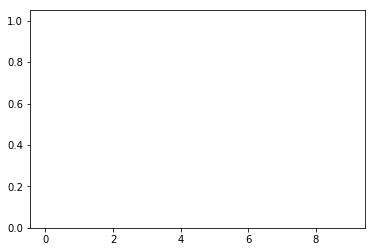

In [11]:
print("Percent of successful episodes: " + str(100.0 * sum(rList)/num_episodes) + "%")

# plt.bar(range(len(rList)), rList, color = "Blue", width = 0.00001)
# plt.show()